# Projet Optimization for ML

*Some codes implemented on this project are based and inspired on the Jupyter Notebooks of Gabriel Peyré and of Clément Royer.*

A few functions useful for all of the parts of the project 

In [6]:
import numpy as np
    
class LeastSquare:
    @staticmethod
    def loss(X, y, w):
        return 1/(2*len(X)) * np.linalg.norm(X@w-y,2)**2
    
    @staticmethod
    def grad(X, y, w):
        return 1/len(X) * X.T @ (X@w-y)
    
    @staticmethod
    def L(X):
        return 1/len(X) * np.linalg.norm(X,2)
    
class Logistic:
    """
    not implemented, but we could easily extend the code that way
    """
    @staticmethod
    def loss(X, y, w):
        pass
    
    @staticmethod
    def grad(X, y, w):
        pass
    
    @staticmethod
    def L(X):
        return np.max(np.linalg.norm(X, axis=0))**2/(4*len(X))

In [7]:
import numpy as np
from functools import partial

class Regularization:
    """
    implementation of the regularization functions
    """

    @staticmethod
    def get(kind, **kwargs):
        if kind=='lasso':
            return Regularization.lasso
        elif kind=='ridge':
            return Regularization.ridge
        elif kind=='norm2':
            return Regularization.norm2
        elif kind=='elasticnet':
            return Regularization.elasticnet
        elif kind=='group_lasso':
            return Regularization.grouplasso
    
    @staticmethod
    def lasso(x, lbda):
        return lbda * np.linalg.norm(x, ord=1)
    
    @staticmethod
    def ridge(x, lbda):
        return lbda / 2 * np.linalg.norm(x, ord=2)**2
    
    @staticmethod
    def norm2(x, lbda):
        return lbda * np.linalg.norm(x, ord=2)
    
    
class Proximal_func:
    """
    implementation of the proximal functions for the different regularizations
    """

    @staticmethod
    def get(kind, **kwargs):
        if kind=='lasso':
            return Proximal_func.lasso
        elif kind=='ridge':
            return Proximal_func.ridge
        elif kind=='norm2':
            return Proximal_func.norm2

    
    @staticmethod
    def lasso(x, lbda):
        return np.maximum(np.abs(x)-lbda, np.zeros(x.shape))*np.sign(x)
    
    @staticmethod
    def ridge(x, lbda):
        return 1/(1+lbda) * x
    
    @staticmethod
    def norm2(x, lbda):
        if np.linalg.norm(x) < 1e-8:
            return x
        return np.maximum(1-lbda/(np.linalg.norm(x)), 0)*x

# Part 1 - Gradient Descent


###  Boston Housing Data

The Boston Housing data is one of the "toy datasets" available in sklearn. We can import and display the dataset description like this:


In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Question 1 : Study of our dataset

In [9]:
from sklearn.datasets import load_boston
boston_data = load_boston()

boston_dataset = pd.DataFrame(data=boston_data.data, columns=boston_data.feature_names)

boston_dataset["prices"] = boston_data.target

c:\Users\adrie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [10]:
boston_dataset.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'prices'],
      dtype='object')

In [11]:
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,prices
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [12]:
boston_dataset.shape #Output:

(506, 14)

In [13]:
boston_dataset.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
prices     0
dtype: int64

Our data set contains no missing values, so we can go directly to the data analysis :

c:\Users\adrie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


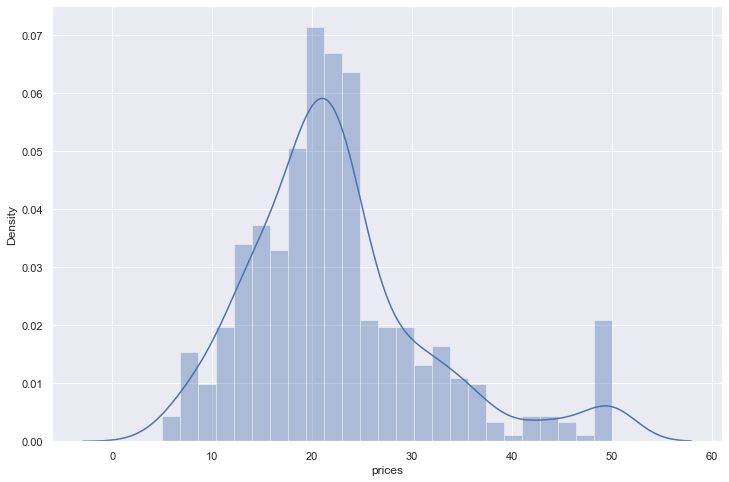

In [14]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.distplot(boston_dataset["prices"], bins=25)
plt.show()

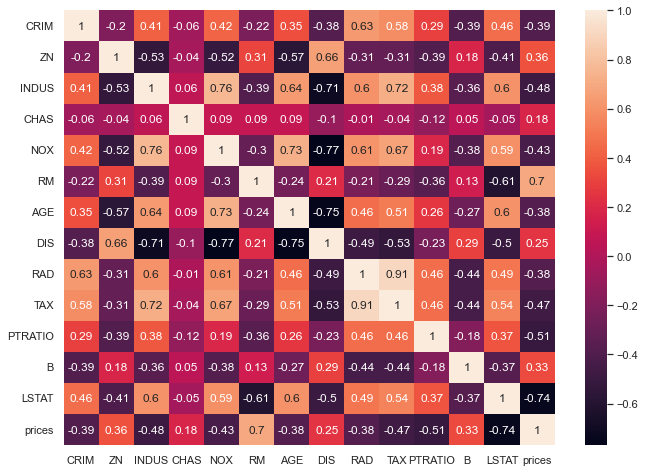

In [15]:
correlation_matrix = boston_dataset.corr().round(2)
sns.set(rc={'figure.figsize':(11, 8)})
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [16]:
boston_dataset.describe

<bound method NDFrame.describe of         CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  prices  
0       15.3  396.90   4.98

In [17]:
#normalize data function
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [18]:
boston_dataset = normalize(boston_dataset)
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,prices
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333


Question 2: Implementation of a gradient descent for regression (l2 loss) with a small ridge penalty. Study of the convergence rate on the training loss for several fixed step sizes. 

In [19]:
y = boston_dataset["prices"]
X = boston_dataset[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]

In [20]:
y = y.values.reshape(y.shape[0], 1)
print(y.shape)

(506, 1)


In [21]:
# Création de la matrice X, inclut le Biais
X_final  = np.hstack((X, np.ones((X.shape[0], 1))))

print(X_final.shape)
print(X_final[:10])

(506, 14)
[[0.00000000e+00 1.80000000e-01 6.78152493e-02 0.00000000e+00
  3.14814815e-01 5.77505269e-01 6.41606591e-01 2.69203139e-01
  0.00000000e+00 2.08015267e-01 2.87234043e-01 1.00000000e+00
  8.96799117e-02 1.00000000e+00]
 [2.35922539e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 5.47997701e-01 7.82698249e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 1.00000000e+00
  2.04470199e-01 1.00000000e+00]
 [2.35697744e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 6.94385898e-01 5.99382080e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 9.89737254e-01
  6.34657837e-02 1.00000000e+00]
 [2.92795719e-04 0.00000000e+00 6.30498534e-02 0.00000000e+00
  1.50205761e-01 6.58555279e-01 4.41812564e-01 4.48544590e-01
  8.69565217e-02 6.67938931e-02 6.48936170e-01 9.94276060e-01
  3.33885210e-02 1.00000000e+00]
 [7.05070075e-04 0.00000000e+00 6.30498534e-02 0.00000000e+00
  1.50205761e-01 6.87104809e-01 5.28321318e-01 4.485

In [22]:
from sklearn.model_selection import train_test_split
#Splitting the data set for training and test in
X_train, X_test, y_train, y_test = train_test_split(X_final,y,test_size=0.3,
                                                    random_state=23)

In [23]:
y_train.shape

(354, 1)

In [24]:
X_train.shape

(354, 14)

In [25]:
theta = np.random.randn(14, 1)

In [26]:
def model(X, theta):
    return X.dot(theta)

In [27]:
def costFunctionReg(X,y,theta,lamda):
    '''Cost function for ridge regression (regularized L2)'''
    #Initialization
    m = len(y)     
    #Vectorized implementation
    h = model(X, theta)
    J_reg = (lamda / (2*m)) * np.sum(np.square(theta))
    J = ((1./(2*m)) * (h - y).T @ (h - y)) + J_reg
    return(J) 

In [28]:
def costFunction(X,y,theta):
    '''Cost function '''
    #Initialization
    m = len(y)     
    #Vectorized implementation
    h = model(X, theta)
    #J_reg = (lamda / (2*m)) * np.sum(np.square(theta))
    J = ((1./(2*m)) * (h - y).T @ (h - y)) 
    return(J) 

In [29]:
def gradient_descent_reg(X,y,theta,alpha,lamda,num_iters):
    '''Gradient descent for ridge regression'''
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    #theta_0_hist, theta_1_hist 
    #Used for three D plot

    for i in range(0, num_iters):
        #Hypothesis function
        h = model(X, theta)
        
        #Grad function in vectorized form
        theta = theta - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * theta )
           
        #Cost function in vectorized form       
        J_history[i] = costFunctionReg(X,y,theta,lamda)
           
        #Calculate the cost for each iteration(used to plot convergence)
        #theta_0_hist.append(theta[0,0])
        #theta_1_hist.append(theta[1,0])   
    return theta.flatten(),J_history
    #, theta_0_hist, theta_1_hist

In [30]:
def gradient_descent(X,y,theta,alpha,num_iters):
    '''Gradient descent for regression'''
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    #theta_0_hist, theta_1_hist 
    #Used for three D plot

    for i in range(0, num_iters):
        #Hypothesis function
        h = model(X, theta)
        
        #Grad function in vectorized form
        theta = theta - alpha * (1/m)* (  (X.T @ (h-y)))
           
        #Cost function in vectorized form       
        J_history[i] = costFunction(X,y,theta)
           
        #Calculate the cost for each iteration(used to plot convergence)
        #theta_0_hist.append(theta[0,0])
        #theta_1_hist.append(theta[1,0])   
    return theta,J_history
    #, theta_0_hist, theta_1_hist

In [31]:
X_train.shape

(354, 14)

In [32]:
theta.shape

(14, 1)

Theoretical test

In [33]:
from numpy.linalg import inv, norm

def lipschitz_constant(X):
  n=X.shape[0]
  return 1/n * norm(np.dot(X.T,X))

In [34]:
L=lipschitz_constant(X_train) #lipschitz_constant parameter for learning rate benchmark
tau = 1/L

Experimental test

In [88]:
theta_final_1, cost_history_1 = gradient_descent_reg(X_train,y_train,theta,alpha = 0.001,lamda = 0.01,num_iters=1000)
theta_final_2, cost_history_2 = gradient_descent_reg(X_train,y_train,theta,alpha = 0.01,lamda = 0.01,num_iters=1000)
theta_final_3, cost_history_3 = gradient_descent_reg(X_train,y_train,theta,alpha = 0.1,lamda = 0.01,num_iters=1000)
theta_final_4, cost_history_4 = gradient_descent_reg(X_train,y_train,theta,alpha = 0.5,lamda = 0.01,num_iters=1000)
theta_final_tau, cost_history_tau = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.01,num_iters=1000)

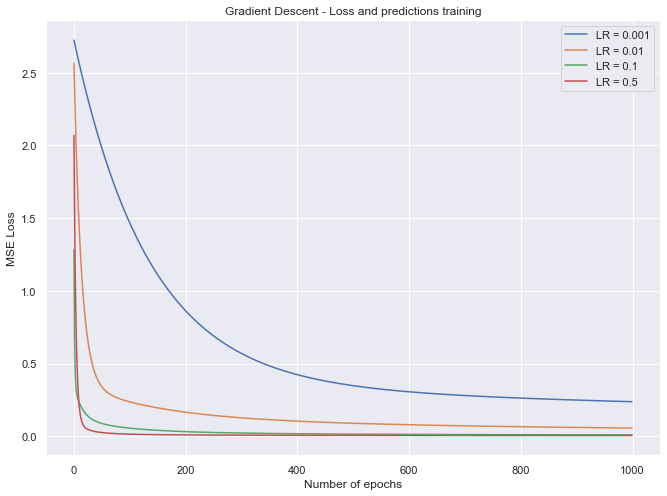

In [118]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_1, label='LR = 0.001')
plt.plot(range(num_epochs), cost_history_2, label='LR = 0.01')
plt.plot(range(num_epochs), cost_history_3, label='LR = 0.1')
plt.plot(range(num_epochs), cost_history_4, label='LR = 0.5')
#plt.plot(range(num_epochs), cost_history_tau, label='LR = tau')


plt.title('Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Question 3 -  Theoritical optimal step choice


Influence of Tau

In [119]:
L=lipschitz_constant(X_train) #lipschitz_constant parameter for learning rate benchmark
L

3.753832605697418

In [51]:
tau_1 = 2/L
tau_2 = 1/L
tau_3 = 0.5/L
tau_4 = 0.1/L
tau_5 = 0.05/L

In [121]:
theta_final_tau_1, cost_history_tau_1 = gradient_descent_reg(X_train,y_train,theta,alpha = tau_1,lamda = 0.01,num_iters=1000)
theta_final_tau_2, cost_history_tau_2 = gradient_descent_reg(X_train,y_train,theta,alpha = tau_2,lamda = 0.01,num_iters=1000)
theta_final_tau_3, cost_history_tau_3 = gradient_descent_reg(X_train,y_train,theta,alpha = tau_3,lamda = 0.01,num_iters=1000)
theta_final_tau_4, cost_history_tau_4 = gradient_descent_reg(X_train,y_train,theta,alpha = tau_4,lamda = 0.01,num_iters=1000)
theta_final_tau_5, cost_history_tau_5 = gradient_descent_reg(X_train,y_train,theta,alpha = tau_5,lamda = 0.01,num_iters=1000)

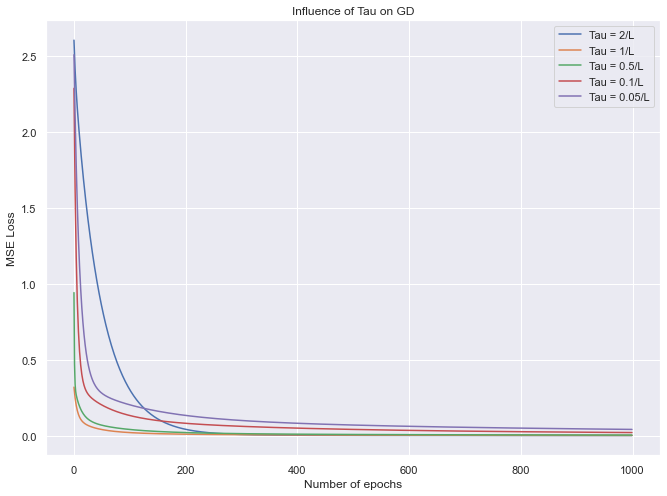

In [122]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_tau_1, label='Tau = 2/L')
plt.plot(range(num_epochs), cost_history_tau_2, label='Tau = 1/L')
plt.plot(range(num_epochs), cost_history_tau_3, label='Tau = 0.5/L')
plt.plot(range(num_epochs), cost_history_tau_4, label='Tau = 0.1/L')
plt.plot(range(num_epochs), cost_history_tau_5, label='Tau = 0.05/L')



plt.title('Influence of Tau on GD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Test

In [123]:
list_theta_exp = [theta_final_1,theta_final_2,theta_final_3,theta_final_4,theta_final_tau]
list_theta_tau = [theta_final_tau_1,theta_final_tau_2,theta_final_tau_3,theta_final_tau_4,theta_final_tau_5]

In [124]:

theta_final_tau

array([-0.32992064,  0.10990268,  0.1255628 ,  0.06369226, -0.04878439,
        0.77254375,  0.00746307, -0.11608776,  0.22899806, -0.25093148,
       -0.10901846,  0.18853029, -0.29223853, -0.01790928])

In [125]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions = model(X_test, theta_final_tau)
predictions

array([ 0.3880735 ,  0.43448547,  0.49153782,  0.30376688,  0.81183783,
        0.22228856,  0.41315457,  0.53907227,  0.62251921,  0.77185634,
        0.27539719,  0.53867549,  0.39311708,  0.42223298,  0.36565831,
        0.30162513,  0.54733319,  0.54538232,  0.46874681,  0.51827142,
        0.38063157,  0.32967038,  0.45364347,  0.40899648,  0.18474028,
        0.31382349,  0.59176074,  0.51349852,  0.5836586 ,  0.90236247,
        0.30943126,  0.24742169,  0.33058638,  0.40550549,  0.28564166,
        0.78592218,  0.36881528,  0.52738565,  0.19363257,  0.68073478,
        0.12316482,  0.21631811,  0.19437215,  0.3327814 ,  0.68376728,
        0.31934716,  0.10394179,  0.33582585,  0.2121664 ,  0.73540543,
        0.37876988, -0.10566753,  0.33734733,  0.31578081,  0.35287376,
        0.60781905,  0.01943965,  0.26610841,  0.28807388,  0.38174585,
        0.27231746,  0.42255023,  0.40123775,  0.9084294 ,  0.56437477,
        0.45992879,  0.40545781,  0.28109698,  0.57132844,  0.19

In [39]:
def mse(y_preds, y):
    '''
    Mean squared error.
    
    PARAMETERS:
    y_preds (numpy.ndarray): Predictions.
    y (numpy.ndarray): Original dependent variable values.
    
    RETURNS:
    mse (float): Mean squared error.
    '''
    mse_error = ((y - y_preds)**2).mean()
    return mse_error

def rmse(y_preds, y):
    '''
    Root Mean squared error.
    
    PARAMETERS:
    y_preds (numpy.ndarray): Predictions.
    y (numpy.ndarray): Original dependent variable values.
    
    RETURNS:
    rmse (float): Root Mean Squared Error.
    '''
    rmse_error = (((y - y_preds)**2).mean())**(1/2)
    return rmse_error

In [40]:
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return 1 - u/v

Here, RMSE and the R2 value are helpful in assesing the model performance.


Comparaison test metrics for differents values of experimental theta

In [50]:
liste_mse_error = []
liste_rmse_error = []
liste_coeff = []
for i in list_theta_exp :
    predictions = model(X_test, i)
    mse_error = mse(predictions,y_test)
    liste_mse_error.append(mse_error)
    rmse_error = rmse(predictions,y_test)
    liste_rmse_error.append(rmse_error)
    coeff = coef_determination(y_test, predictions)
    liste_coeff.append(coeff)

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of experimental Theta')

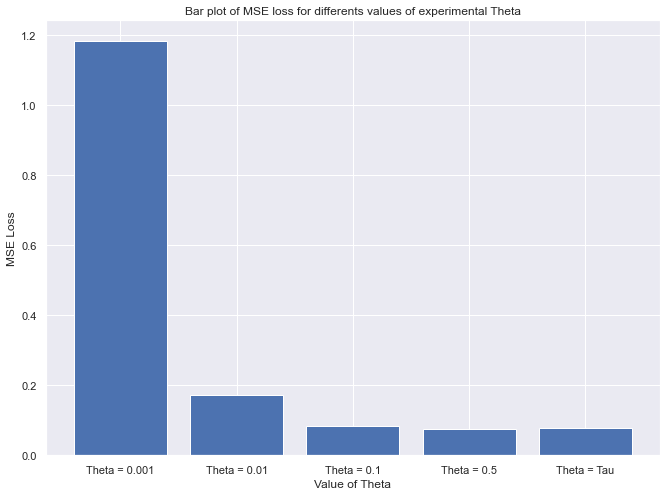

In [435]:
names = ['Theta = 0.001', 'Theta = 0.01', 'Theta = 0.1','Theta = 0.5','Theta = Tau'] # nom des barres

values = liste_mse_error

plt.bar(names, values)
plt.xlabel("Value of Theta")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of experimental Theta")

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of experimental LR')

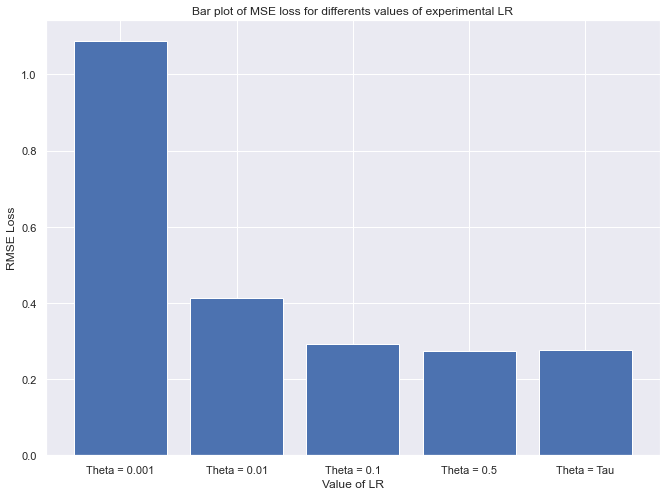

In [436]:
names = ['Theta = 0.001', 'Theta = 0.01', 'Theta = 0.1','Theta = 0.5','Theta = Tau'] # nom des barres

values = liste_rmse_error

plt.bar(names, values)
plt.xlabel("Value of LR")
plt.ylabel("RMSE Loss")
plt.title("Bar plot of MSE loss for differents values of experimental LR")

Text(0.5, 1.0, 'Bar plot of Coefficient Determination for differents values of experimental Theta')

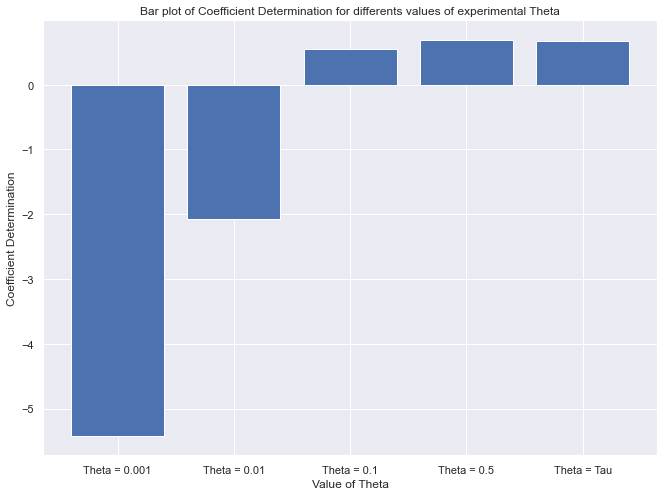

In [451]:
names = ['Theta = 0.001', 'Theta = 0.01', 'Theta = 0.1','Theta = 0.5','Theta = Tau'] # nom des barres

values = liste_coeff

plt.bar(names, values)
plt.xlabel("Value of Theta")
plt.ylabel("Coefficient Determination")
plt.title("Bar plot of Coefficient Determination for differents values of experimental Theta")

Comparaison test metrics for differents values of theoretical theta

In [96]:
liste_mse_error_tau = []
liste_rmse_error_tau = []
liste_coeff_tau = []
for i in list_theta_tau :
    predictions_tau = model(X_test, i)
    mse_error_tau = mse(predictions_tau,y_test)
    liste_mse_error_tau.append(mse_error_tau)
    rmse_error_tau = rmse(predictions_tau,y_test)
    liste_rmse_error_tau.append(rmse_error_tau)
    coeff_tau = coef_determination(y_test, predictions_tau)
    liste_coeff_tau.append(coeff_tau)

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of theoretical Theta')

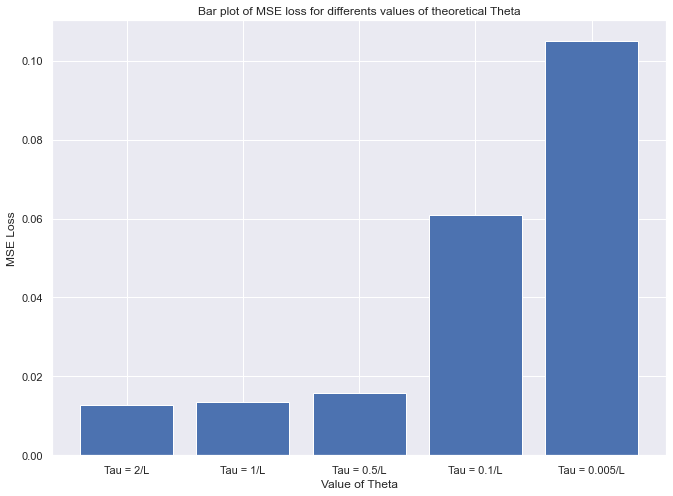

In [454]:
names = ['Tau = 2/L', 'Tau = 1/L', 'Tau = 0.5/L','Tau = 0.1/L','Tau = 0.005/L'] # nom des barres

values = liste_mse_error_tau

plt.bar(names, values)
plt.xlabel("Value of Theta")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of theoretical Theta")

Text(0.5, 1.0, 'Bar plot of RMSE loss for differents values of theoretical Theta')

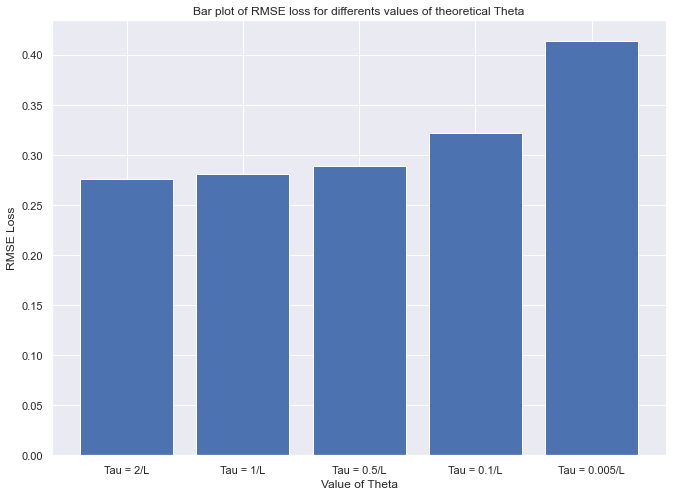

In [44]:
names = ['Tau = 2/L', 'Tau = 1/L', 'Tau = 0.5/L','Tau = 0.1/L','Tau = 0.005/L'] # nom des barres

values = liste_rmse_error_tau

plt.bar(names, values)
plt.xlabel("Value of Theta")
plt.ylabel("RMSE Loss")
plt.title("Bar plot of RMSE loss for differents values of theoretical Theta")

Text(0.5, 1.0, 'Bar plot of Coefficient Determination for differents values of theoretical Theta')

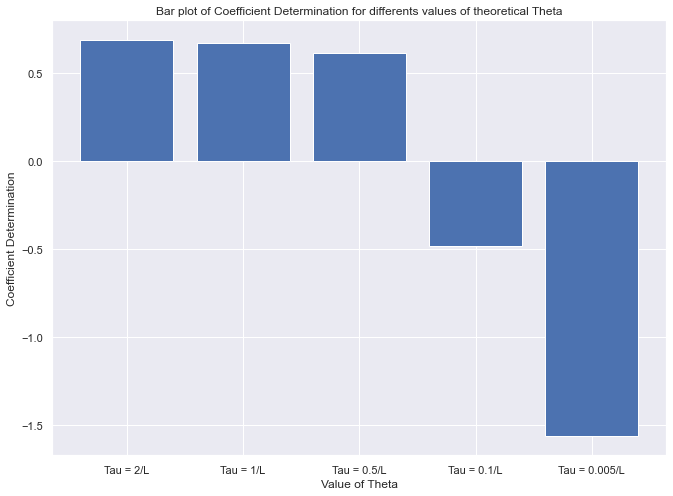

In [456]:
names = ['Tau = 2/L', 'Tau = 1/L', 'Tau = 0.5/L','Tau = 0.1/L','Tau = 0.005/L'] # nom des barres

values = liste_coeff_tau

plt.bar(names, values)
plt.xlabel("Value of Theta")
plt.ylabel("Coefficient Determination")
plt.title("Bar plot of Coefficient Determination for differents values of theoretical Theta")

Question 4 - Regression performance on the test set as the ridge penalty changes. 

In [97]:
tau = 1/L
theta_final_lamda_1_full, cost_history_lamda_1_full = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 1,num_iters=1000)
theta_final_lamda_1, cost_history_lamda_1 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.5,num_iters=1000)
theta_final_lamda_2, cost_history_lamda_2 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.3,num_iters=1000)
theta_final_lamda_3, cost_history_lamda_3 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.1,num_iters=1000)
theta_final_lamda_4, cost_history_lamda_4 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.01,num_iters=1000)
theta_final_lamda_5, cost_history_lamda_5 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0.001,num_iters=1000)
theta_final_lamda_0, cost_history_lamda_0 = gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = 0,num_iters=1000)

In [52]:
liste_lamdas=[1,0.5,0.3,0.1,0.01,0.001,0]

In [290]:
liste_thetas = [theta_final_lamda_1_full,theta_final_lamda_1,theta_final_lamda_2,theta_final_lamda_3,theta_final_lamda_4,theta_final_lamda_5,theta_final_lamda_0]

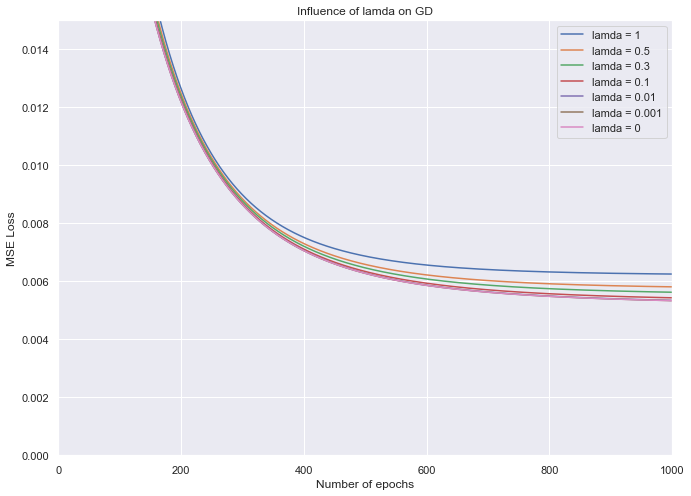

In [225]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_lamda_1_full, label='lamda = 1')
plt.plot(range(num_epochs), cost_history_lamda_1, label='lamda = 0.5')
plt.plot(range(num_epochs), cost_history_lamda_2, label='lamda = 0.3')
plt.plot(range(num_epochs), cost_history_lamda_3, label='lamda = 0.1')
plt.plot(range(num_epochs), cost_history_lamda_4, label='lamda = 0.01')
plt.plot(range(num_epochs), cost_history_lamda_5, label='lamda = 0.001')
plt.plot(range(num_epochs), cost_history_lamda_0, label='lamda = 0')


plt.xlim([0, 1000])
plt.ylim([0, 0.015])
plt.title('Influence of lamda on GD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

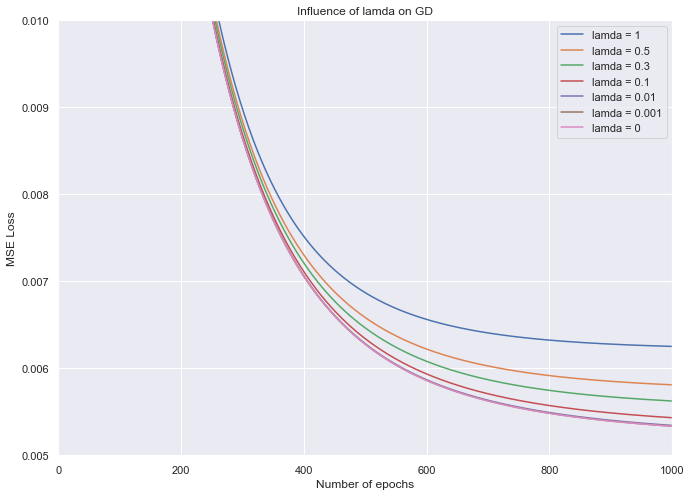

In [226]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_lamda_1_full, label='lamda = 1')
plt.plot(range(num_epochs), cost_history_lamda_1, label='lamda = 0.5')
plt.plot(range(num_epochs), cost_history_lamda_2, label='lamda = 0.3')
plt.plot(range(num_epochs), cost_history_lamda_3, label='lamda = 0.1')
plt.plot(range(num_epochs), cost_history_lamda_4, label='lamda = 0.01')
plt.plot(range(num_epochs), cost_history_lamda_5, label='lamda = 0.001')
plt.plot(range(num_epochs), cost_history_lamda_0, label='lamda = 0')


plt.xlim([0, 1000])
plt.ylim([0.005, 0.01])
plt.title('Influence of lamda on GD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison test metrics for differents values of lamdas

C:\Users\adrie\AppData\Local\Temp\ipykernel_16624\3336271755.py:7: RuntimeWarning: overflow encountered in double_scalars
  J_reg = (lamda / (2*m)) * np.sum(np.square(theta))
c:\Users\adrie\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\adrie\AppData\Local\Temp\ipykernel_16624\3336271755.py:8: RuntimeWarning: overflow encountered in matmul
  J = ((1./(2*m)) * (h - y).T @ (h - y)) + J_reg
C:\Users\adrie\AppData\Local\Temp\ipykernel_16624\3336271755.py:7: RuntimeWarning: overflow encountered in square
  J_reg = (lamda / (2*m)) * np.sum(np.square(theta))
C:\Users\adrie\AppData\Local\Temp\ipykernel_16624\3772196448.py:12: RuntimeWarning: overflow encountered in square
  mse_error = ((y - y_preds)**2).mean()


0.001
0.07768310409645968


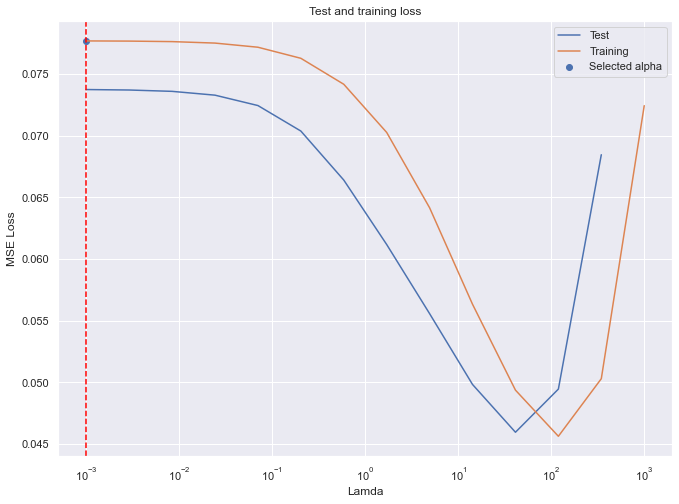

In [98]:
lamdas = np.logspace(-3, 3, 14)

train_values = []
test_values = []

for i in lamdas:
  
  theta_final_train_l2, cost_history_train= gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = i,num_iters=1000)
  theta_final_test, cost_history_test= gradient_descent_reg(X_test,y_test,theta,alpha = tau,lamda = i,num_iters=1000)
  
  predictions_test = model(X_test, theta_final_train_l2)
  predictions_train = model(X_train, theta_final_test)


  mse_train= mse(predictions_train,y_train)
  mse_test = mse(predictions_test,y_test)

  train_values.append(mse_train)
  test_values.append(mse_test)

best_lamda_index = np.argmin(mse_test)
best_alpha = lamdas[best_lamda_index]
best_value = test_values[best_lamda_index]

print(best_alpha)
print(best_value)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(lamdas, train_values, label="Test")
plt.plot(lamdas, test_values, label="Training")
plt.scatter([best_alpha], [best_value], label="Selected alpha")
plt.axvline(best_alpha, color='red', linestyle='--')

#plt.ylim([0,0.10])

plt.xscale("log")

plt.title('Test and training loss')
plt.xlabel("Lamda")
plt.ylabel("MSE Loss")


plt.legend(loc="best")
plt.show() 

In [101]:
n_iter = 400
q = 14
lbda_list = np.logspace(-3,3,q)

J_train_Ridge = np.zeros(q) # the energy on the training set
J_test_Ridge = np.zeros(q) # the energy on the test set
E_train_Ridge = np.zeros(q) # the relative training error
E_test_Ridge = np.zeros(q) # the relative test error
W_Ridge = np.zeros((q,p)) # the coefficients


for i,lbda in enumerate(lbda_list):
    theta_final_l2, cost_history_train= gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = i,num_iters=1000)
    
    J_train_Ridge[i] = LeastSquare.loss(X_train,y_train,theta_final_train_l2)+Regularization.ridge(theta_final_train_l2, lbda)
    J_test_Ridge[i] = LeastSquare.loss(X_test,y_test,theta_final_train_l2)+Regularization.ridge(theta_final_train_l2, lbda)
    E_train_Ridge[i] = LeastSquare.loss(X_train,y_train,theta_final_train_l2)/np.linalg.norm(y_train)
    E_test_Ridge[i] = LeastSquare.loss(X_test,y_test,theta_final_train_l2)/np.linalg.norm(y_test)
    #W_Ridge[i] = theta_final_train_l2.flatten()
    
# find optimal Lambda
i = E_test_Ridge.argmin(axis=0)
lambda_Ridge = lbda_list[i]
w_Ridge = W_Ridge[i][:,None]
print( 'Ridge: ' + str(E_test_Ridge.min()*100) + '%' )
print('lambda = {}'.format(lambda_Ridge))
# print('w = {}'.format(w_Ridge))

Ridge: 101.6470776597684%
lambda = 0.001


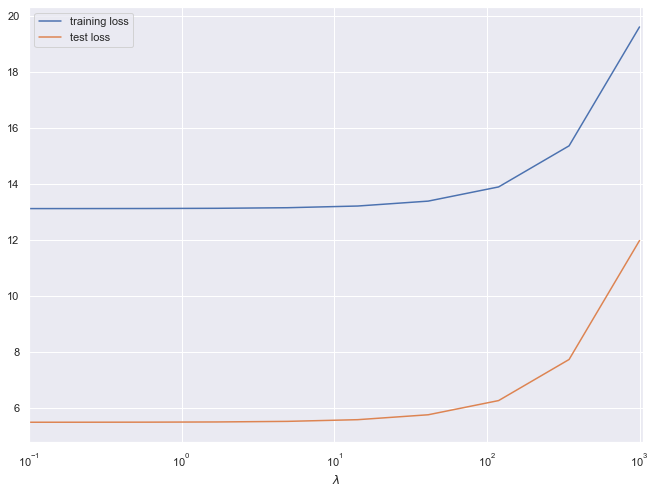

In [105]:
plt.clf
plt.plot(lbda_list, J_train_Ridge, label='training loss')
plt.plot(lbda_list, J_test_Ridge, label='test loss')
plt.axvline(lambda_Ridge, color='red', linestyle='--')
plt.xlabel('$\lambda$')
#plt.xlim(0.10000)
plt.xscale('log')
plt.legend()
plt.show()

In [227]:
liste_mse_error_lamdas = []
liste_rmse_error_lamdas = []
liste_coeff_lamdas = []
for i in liste_thetas :
    predictions_lamdas = model(X_test, i)
    mse_error_lamdas = mse(predictions_lamdas,y_test)
    liste_mse_error_lamdas.append(mse_error_lamdas)
    rmse_error_lamdas = rmse(predictions_lamdas,y_test)
    liste_rmse_error_lamdas.append(rmse_error_lamdas)
    coeff_lamdas = coef_determination(y_test, predictions_lamdas)
    liste_coeff_lamdas.append(coeff_lamdas)

In [139]:
liste_mse_error_lamdas

[0.012821979067447043,
 0.012685528150963367,
 0.012676283431992234,
 0.012709715943463847,
 0.01274302923802959,
 0.012747093946741337,
 0.012747554274201617]

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of Lamdas')

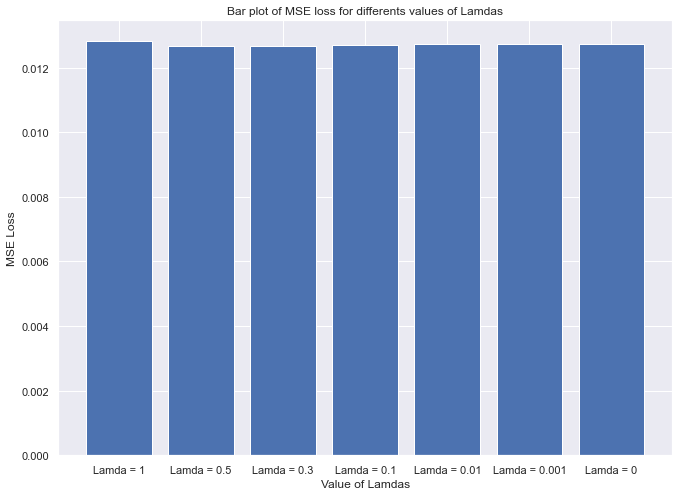

In [140]:
names = ['Lamda = 1', 'Lamda = 0.5', 'Lamda = 0.3', 'Lamda = 0.1','Lamda = 0.01','Lamda = 0.001','Lamda = 0'] # nom des barres

values = liste_mse_error_lamdas

plt.bar(names, values)
plt.xlabel("Value of Lamdas")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of Lamdas")

Text(0.5, 1.0, 'Bar plot of RMSE loss for differents values of Lamdas')

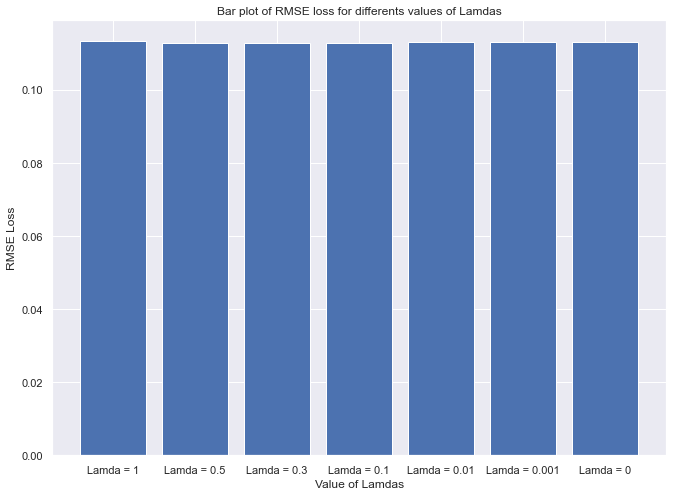

In [141]:
names = ['Lamda = 1', 'Lamda = 0.5', 'Lamda = 0.3', 'Lamda = 0.1','Lamda = 0.01','Lamda = 0.001','Lamda = 0'] # nom des barres

values = liste_rmse_error_lamdas

plt.bar(names, values)
plt.xlabel("Value of Lamdas")
plt.ylabel("RMSE Loss")
plt.title("Bar plot of RMSE loss for differents values of Lamdas")

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of Coefficient')

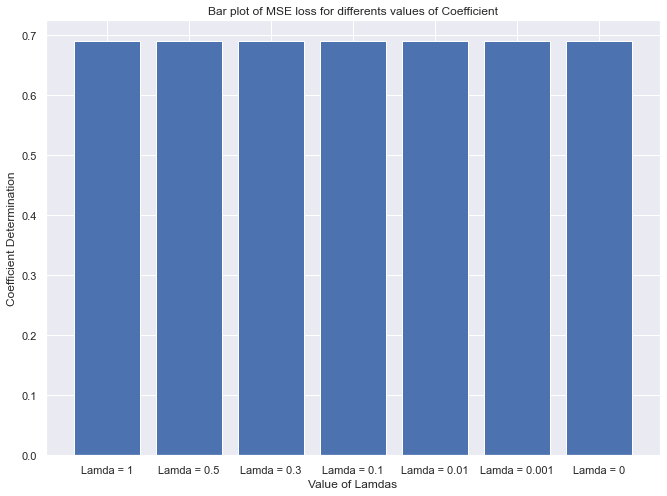

In [142]:
names = ['Lamda = 1', 'Lamda = 0.5', 'Lamda = 0.3', 'Lamda = 0.1','Lamda = 0.01','Lamda = 0.001','Lamda = 0'] # nom des barres

values = coeff_lamdas

plt.bar(names, values)
plt.xlabel("Value of Lamdas")
plt.ylabel("Coefficient Determination")
plt.title("Bar plot of MSE loss for differents values of Coefficient")

## Part 2 - automatic differentiation

In [179]:
import random
import tqdm

We will assume that each primitive function returns both the function value and the associated VJP.

Question 1: implement the relu function and its VJP in the format above. Using the finite difference equation (slide 13), make sure that the VJP is correct numerically.

In [180]:
def relu(x):
  """
  Args:
    - x, an array structure

  Returns:
    value :  value of the function ReLU(x) 
    vjp : function vjp to easily compute Relu vjp
  """
  value = np.maximum(x,0) #by defintion of the ReLU function 
  
  def vjp(u):
    derivate_relu = (x > 0) * 1 #by definition of the ReLU function and its derivative
    vjp_wrt_x = np.multiply(u,derivate_relu) 
    return vjp_wrt_x,  

  return value, vjp

We then test our implemented function with the same annotation to the course

In [181]:
x = np.array([4])
val, vjp = relu(x) #appel de la fonction relu

eps=0.01
df = (relu(x+eps)[0] - relu(x)[0])/eps

array = np.array([8])
print(vjp(array))
print(array*df)

(array([8]),)
[8.]


The two methods give the same results indeed. The VJP is correct numerically.

Question 2: reusing dot and relu, implement a 2-layer MLP with a relu activation

In [182]:
#we import dot from the google doc
def dot(W, x):
  """
  Args:
    W: matrix of shape (n1,n)
    x: array of shape n 

  Returns:
    value : value of the function dot(W,x) 
    vjp : function vjp to easily compute dot product vjp
  """
  value = np.dot(W, x)

  def vjp(u):
    return np.outer(u, x), np.dot(W.T,u)

  return value, vjp

In [183]:
def mlp2(x, W1, W2):

    """
    Definition of a MLP-2 layer architecture with ReLU function activation

    Args:
        x: array of shape n 
        W1: matrix of shape (n1,n)
        W2: matrix of shape (1,n1)
    """

    x1 = dot(W1,x)[0] #1st linear layer 
    x2 = relu(x1)[0] #ReLU activation function
    x3 = dot(W2,x2)[0] #2nd linear layer
    value = x3

    def vjp(u):

        #calcul scnd VJP
        

        vjp_jacobian_W2 = dot(W2,x2)[1](u) 
        vjp_jacobian_dot_W2_wrt_x2 = vjp_jacobian_W2[1] #2nd vjp, with respect to x2
        vjp_jacobian_relu_wrt_x1 = relu(x1)[1](vjp_jacobian_dot_W2_wrt_x2)[0] #apply relu function 

        #Calcul 1st VJP
        
        vjp_jacobian_W1 =  dot(W1,x)[1](vjp_jacobian_relu_wrt_x1) 
        vjp_wrt_W1 = vjp_jacobian_W1[0] #vjp to W1
        
        
        vjp_wrt_W2 = vjp_jacobian_W2[0] #vjp to W2

        vjp_wrt_x = vjp_jacobian_W1[1] #vjp to x
        
        return vjp_wrt_x,vjp_wrt_W1, vjp_wrt_W2

    return value, vjp

Apply mlp2 function with experimental values :

In [184]:
x = np.array([1,2])
W1 = np.array([[1,2],[2,1]])
W2 = np.array([[2,3],[3,2]])
print(mlp2(x,W1,W2))

(array([22, 23]), <function mlp2.<locals>.vjp at 0x0000019C8A5CE940>)


Question 3: implement the squared loss VJP

In [185]:
def squared_loss(y_pred, y):
    """
    This function defines squared-loss between 2 vectors
        
    Returns:
        value : value of the function squared_loss(y_pred, y)
        vjp : function vjp to easily compute vjp of the squared loss
    """

    residual_values = y_pred - y
    values = 0.5 * np.sum(residual_values ** 2)

    def vjp(u):
        vjp_y_pred = np.multiply(residual_values,u)
        vjp_y = -np.multiply(residual_values,u)
        return vjp_y_pred, vjp_y
    

    #requires every output to be an array.
    return np.array([values]), vjp

Apply squared_loss function with experimental values :

In [186]:
y_pred = np.array([1,2,5,4])
y = np.array([0.3,1,4.9,8.7])

print(squared_loss(y_pred,y))

(array([11.795]), <function squared_loss.<locals>.vjp at 0x0000019C8A5CE310>)


Question 4: implement the loss by composing mlp2 and squared_loss

In [187]:
def loss(x, y, W1, W2):
    """
    Definition of the loss, with applying squared_loss and mlp2 function 

    Args:
        x: array of shape n 
        y: array of shape n 
        W1: matrix of shape (n1,n)
        W2: matrix of shape (1,n1)
    """

    y_pred = mlp2(x, W1, W2)[0]
    values = squared_loss(y_pred, y)[0]

    def vjp(u):
        
        vjp_squared_loss = squared_loss(y_pred, y)[1](u)
        vjp_to_y = vjp_squared_loss[1] # vjp to y 

        vjp_mlp2 = mlp2(x, W1, W2)[1](vjp_squared_loss[0]) #update mlp vjp parameters

        vjp_to_W2 = vjp_mlp2[2] # vjp to W2
        vjp_to_W1 = vjp_mlp2[1] # vjp to W1
        vjp_to_x = vjp_mlp2[0] # vjp to Wx
        
        return vjp_to_x, vjp_to_y, vjp_to_W1, vjp_to_W2

    return values, vjp

Now let's numerically test numerically our gradient and architecture

In [188]:
#retrieve numerically the gradient values 

def gradient_vjp_num(f,x,y,W1,W2,u, eps=1e-3): 
    
    def direction_gradient(i): # to define each direction in the space
        vector = np.zeros(len(x)) #init
        vector[i] = 1
        return vector
  
    Jacobian_matrix = np.zeros((len(f(x,y,W1,W2)[0]),len(x))) #init
    for i in range (len(x)):
        Jacobian_matrix[:,i] = (f(x + eps * direction_gradient(i),y,W1,W2)[0] - f(x,y,W1,W2)[0]) / eps #finite difference
  
    return np.dot(Jacobian_matrix.T,u) 

In [189]:
size_output = 8 #size of the ouput vector for the MLP
size_w = 4 #size W1 & W2


# Random Generation of x and u
x = np.linspace(start = -2, stop = 2, num = 30) 
y = np.linspace(start = -2, stop = 2, num = size_output)

W1 = np.random.rand(size_w,len(x))
W2 = np.random.rand(size_output,size_w)
u = np.random.rand(1) #scalar with size 1

relu_numerical_vjp = gradient_vjp_num(loss,x,y,W1,W2,u, eps=1e-2)
implemented_vjp = loss(x, y, W1, W2)[1](u)[0]

In [190]:
# numeric results
print(relu_numerical_vjp[0])

0.16808402359262803


In [191]:
# vjp results
print(implemented_vjp[0])

0.16798289986059078


The gradient is numerically verified with the rounding


Question 5: implement an MLP with an arbitrary number of layers.

In [192]:
#Implementation based on the previous function mlp2(x, W1, W2)

def MLP_archi(x, *args):
    
    """
    MLP Architecture with ReLU function activation
    
    """
    n_layers = len(args) 
    x_hidden = [] #store intermediate hidden values of our architecture
    input = x 
    
    for layer in range(n_layers-1): #forward step
        x_current_layer =  [0,0] 

        x = dot(args[layer],x)[0] #linear function
        x_current_layer[0] = x
        
        x = relu(x)[0] #ReLU activation 
        x_current_layer[1] = x
        
        x_hidden.append(x_current_layer) #storing value
    
    value_last_layer = dot(args[n_layers-1],x_hidden[n_layers-2][1])[0] #last layer

    def vjp(u):
        
        #initialization of our list
        list_of_vjp = []

        #last layer
        vjp_dot_last_layer = dot(args[n_layers-1],x_hidden[n_layers-2][1])[1](u) 
        vjp_weights = vjp_dot_last_layer[0] # keep the 1st vjp
        vjp_x = vjp_dot_last_layer[1] 

        list_of_vjp.insert(0,vjp_weights)
        
        for layer in range(n_layers-2,0,-1): #for every layer, vjp computation
            vjp_relu_x = relu(x_hidden[layer][0])[1](vjp_x)[0] #backward relu
            vjp_dot = dot(args[layer],x_hidden[layer-1][1])[1](vjp_relu_x) #backward dot 
            vjp_x = vjp_dot[1] 
            vjp_weights = vjp_dot[0] #keep weights

            list_of_vjp.insert(0,vjp_weights)
        
        #first layer
        vjp_relu_x = relu(x_hidden[0][0])[1](vjp_x)[0] #backward relu
        vjp_dot = dot(args[0],input)[1](vjp_relu_x) #backward dot 
        vjp_x = vjp_dot[1] 
        vjp_weights = vjp_dot[0] #keep weights

        list_of_vjp.insert(0,vjp_x)
        list_of_vjp.insert(0,vjp_weights) #update

        return list_of_vjp

    return value_last_layer, vjp

In [193]:
def loss_MLP(x, y, *args):
    """
    Definition of the loss of our general mlp

    Args:
        x: an array of shape n 
        y: an array of shape n 
        *args: matrix of layer
    """

    y_pred = MLP_archi(x, *args)[0] #prediction calculate
    loss = squared_loss(y_pred, y)[0]

    def vjp_loss(u):
        
        vjp_squared_loss = squared_loss(y_pred, y)[1](u)
        vjp_wrt_y = vjp_squared_loss[1] # we keep the vjp with respect to y 

        vjp_mlp = MLP_archi(x, *args)[1](vjp_squared_loss[0])

        list_of_vjp = []
        list_of_vjp.append(vjp_wrt_y)# add vjp wrt to y
        list_of_vjp.append(vjp_mlp[0])# add vjp wrt to x 

        list_of_vjp = list_of_vjp + vjp_mlp[1:] #add vjp to weights 
        
        return list_of_vjp

    return loss, vjp_loss

Question 6: implement SGD to train your MLP on a dataset of your choice. Study the impact of depth (number of layers) and width (number of hidden units).

Applicaton of SGD in our dataset Housing Boston - MLP with 2 layers

In [136]:
#test with mlp general
learning_rate = 1e-4
nb_epochs = 100
nb_samples = 150

#test with 2 layers with 2 and 3 neurons
input_dim = X_train.shape[1]
hidden_dim_1 = 2
hidden_dim_2 = 3

#weights initialisation
W1 = np.random.normal(loc=0, scale=1./np.sqrt(input_dim),size=(hidden_dim_1, input_dim))
W2 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_1),size=(hidden_dim_2, hidden_dim_1))

list_training_loss, list_test_loss = [], []

for epoch in range(nb_epochs):

    list_train_err = []
    list_test_err = []

    for n in range(nb_samples):

        #train part
        random_index_train = np.random.randint(nb_samples) #index taken randomly (stochastic)
        loss_train_it = loss_MLP(X_train[random_index_train], y_train[random_index_train], W1, W2)[0] #update loss with application of loss_MLP function on our X_train Boston dataset

        grad = loss_MLP(X_train[random_index_train], y_train[random_index_train], W1, W2)[1](1) #update gradient

        W1 = W1 - learning_rate*grad[2] #update w1
        W2 = W2 - learning_rate*grad[3] #update w2

        list_train_err.append(loss_train_it)

        #test part
        random_index_test = np.random.randint(nb_samples)
        loss_test_it = loss_MLP(X_train[random_index_test], y_train[random_index_test], W1, W2)[0]
        list_test_err.append(loss_test_it)

    list_training_loss.append(np.array(list_train_err).mean()) #list updates
    list_test_loss.append(np.array(list_test_err).mean())

With 2 neurons per layer

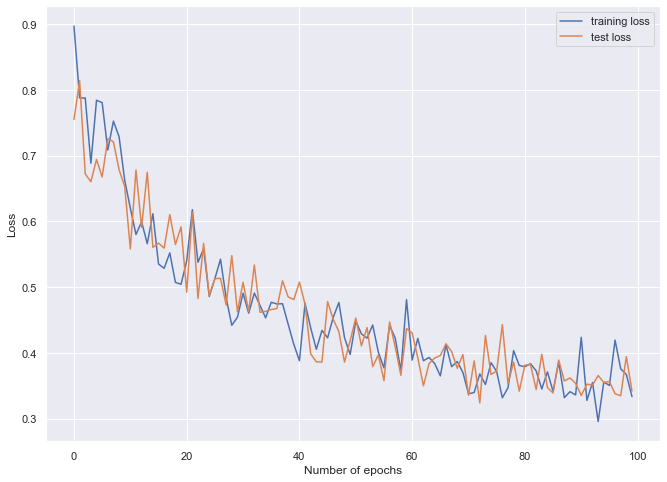

The minimal training error reached is : 0.29551606871366637
The minimal test error reached is : 0.3237368588849054


In [116]:
plt.plot(np.array(list_training_loss), label='training loss')
plt.plot(np.array(list_test_loss), label='test loss')
plt.legend()

plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")

plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.show()

print("The minimal training error reached is : " + str(np.min(list_training_loss)))
print("The minimal test error reached is : " + str(np.min(list_test_loss)))

Applicaton of SGD - MLP with 4 layers

In [194]:
#test with mlp general
learning_rate = 1e-4
nb_epochs = 100
nb_samples = 150

#test with 4 layers
input_dim = X_train.shape[1]
hidden_dim_1 = 2
hidden_dim_2 = 3
hidden_dim_3 = 4
hidden_dim_4 = 5

#weights initialisation
W1 = np.random.normal(loc=0, scale=1./np.sqrt(input_dim),size=(hidden_dim_1, input_dim))
W2 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_1),size=(hidden_dim_2, hidden_dim_1))
W3 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_2),size=(hidden_dim_3, hidden_dim_2))
W4 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_3),size=(hidden_dim_4, hidden_dim_3))

list_training_loss, list_test_loss = [], []

for epoch in range(nb_epochs):

    list_train_err = []
    list_test_err = []
    for n in range(nb_samples):
        random_index_train = np.random.randint(nb_samples) #index taken randomly (stochastic)
        loss_train_it = loss_MLP(X_train[random_index_train], y_train[random_index_train], W1, W2,W3,W4)[0] #update loss with application of loss_MLP function on our X_train Boston dataset

        grad = loss_MLP(X_train[random_index_train], y_train[random_index_train], W1, W2, W3, W4)[1](1) #update gradient

        W1 = W1 - learning_rate*grad[2] #update W1
        W2 = W2 - learning_rate*grad[3] #update W2
        W3 = W3 - learning_rate*grad[4] #update W3
        W4 = W4 - learning_rate*grad[5] #update W4

        list_train_err.append(loss_train_it)

        random_index_test = np.random.randint(nb_samples)
        loss_test_it = loss_MLP(X_train[random_index_test], y_train[random_index_test], W1, W2)[0]
        list_test_err.append(loss_test_it)

    list_training_loss.append(np.array(list_train_err).mean()) #list updates train
    list_test_loss.append(np.array(list_test_err).mean()) #list updates test

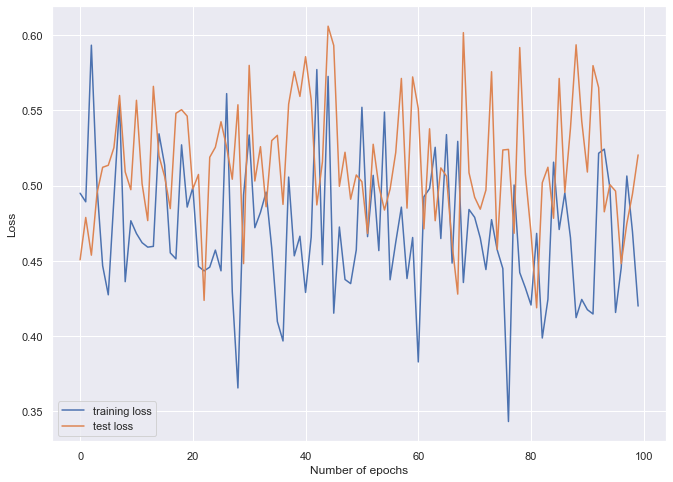

The minimal training error reached is : 0.3432333054195032
The minimal test error reached is : 0.41879311050765955


In [195]:
plt.plot(np.array(list_training_loss), label='training loss')
plt.plot(np.array(list_test_loss), label='test loss')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

print("The minimal training error reached is : " + str(np.min(list_training_loss)))
print("The minimal test error reached is : " + str(np.min(list_test_loss)))

Applicaton of SGD - MLP with 6 layers

In [175]:
#test with mlp general
learning_rate = 1e-4
nb_epochs = 100

#test with 6 layers
input_dim = X_train.shape[1]
hidden_dim_1 = 2 #number of the weights for each layer
hidden_dim_2 = 3
hidden_dim_3 = 4
hidden_dim_4 = 5
hidden_dim_5 = 6
hidden_dim_6 = 7


#weights initialisation
W1 = np.random.normal(loc=0, scale=1./np.sqrt(input_dim),size=(hidden_dim_1, input_dim))
W2 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_1),size=(hidden_dim_2, hidden_dim_1))
W3 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_2),size=(hidden_dim_3, hidden_dim_2))
W4 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_3),size=(hidden_dim_4, hidden_dim_3))
W5 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_4),size=(hidden_dim_5, hidden_dim_4))
W6 = np.random.normal(loc=0, scale=1./np.sqrt(hidden_dim_5),size=(hidden_dim_6, hidden_dim_5))

list_training_loss, list_test_loss = [], []

for epoch in range(nb_epochs):

    list_train_err = []
    list_test_err = []
    for n in range(nb_samples):
        index_random_train = np.random.randint(nb_samples) #index taken randomly (stochastic)
        loss_train_it = loss_MLP(X_train[index_random_train], y_train[index_random_train], W1, W2, W3, W4, W5, W6)[0] #update loss with application of loss_MLP function on our X_train Boston dataset

        grad = loss_MLP(X_train[index_random_train], y_train[index_random_train], W1, W2,  W3, W4, W5, W6)[1](1) #update gradient

        W1 = W1 - learning_rate*grad[2] #update W1
        W2 = W2 - learning_rate*grad[3] #update W2
        W3 = W3 - learning_rate*grad[4] #update W3
        W4 = W4 - learning_rate*grad[5] #update W4
        W5 = W5 - learning_rate*grad[6] #update W5
        W6 = W6 - learning_rate*grad[7] #update W6

        list_train_err.append(loss_train_it)

        index_random_test = np.random.randint(nb_samples)
        loss_test_it = loss_MLP(X_train[index_random_test], y_train[index_random_test], W1, W2, W3, W4, W5, W6)[0]
        list_test_err.append(loss_test_it)

    list_training_loss.append(np.array(list_train_err).mean())
    list_test_loss.append(np.array(list_test_err).mean())

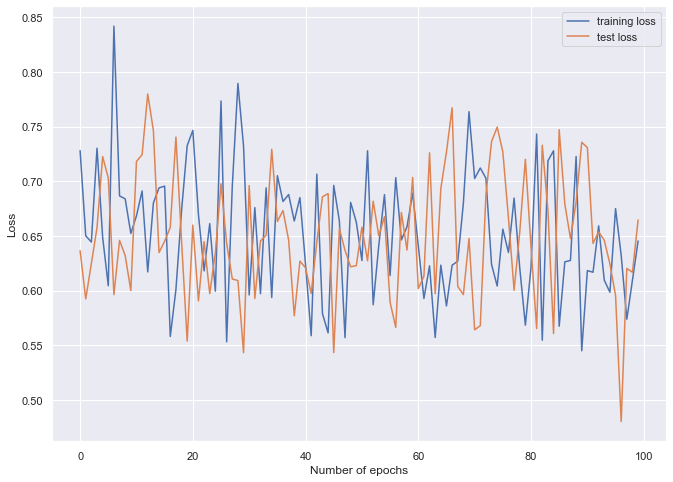

The minimal training error reached is : 0.5449456559299103
The minimal test error reached is : 0.48022854376806623


In [176]:
plt.plot(np.array(list_training_loss), label='training loss')
plt.plot(np.array(list_test_loss), label='test loss')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

print("The minimal training error reached is : " + str(np.min(list_training_loss)))
print("The minimal test error reached is : " + str(np.min(list_test_loss)))

The interpretation of these graphical results is provided in the project report.

# Projet 3 - SGD

Question 1 - Implement stochastic gradient and compare its performance with that of your gradient descent implementation

In [70]:
def stochastic_gradient_descent(X, y,theta,alpha,num_iters):
    m = np.size(y)
    J_history = np.zeros(num_iters)
    
    for it in range(0, num_iters):
        cost = 0.0
        for i in range(m):
            random_select = np.random.randint(0, m)
            

            x_i = X[random_select,:].reshape(1,X.shape[1])
            h = model(x_i, theta)
            #print(x_i)
            #print(h)
            y_i = y[random_select].reshape(1,1)
            #print(y_i)

            theta = theta -  alpha * (1 / m) * ( (x_i.T @ (h - y_i)))
            cost += costFunction(x_i,y_i,theta)
        J_history[it] = cost

    return theta, J_history

In [71]:
theta_final_sgd_1, cost_history_sgd_1 = stochastic_gradient_descent(X_train,y_train,theta,alpha = 0.001,num_iters=1000)
theta_final_sgd_2, cost_history_sgd_2 = stochastic_gradient_descent(X_train,y_train,theta,alpha = 0.01,num_iters=1000)
theta_final_sgd_3, cost_history_sgd_3 = stochastic_gradient_descent(X_train,y_train,theta,alpha = 0.1,num_iters=1000)
theta_final_sgd_4, cost_history_sgd_4 = stochastic_gradient_descent(X_train,y_train,theta,alpha = 0.5,num_iters=1000)
theta_final_sgd_tau, cost_history_sgd_tau = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau,num_iters=1000)

In [108]:
theta_final_sgd_tau_1, cost_history_sgd_tau_1 = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau_1,num_iters=1000)
theta_final_sgd_tau_2, cost_history_sgd_tau_2 = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau_2,num_iters=1000)
theta_final_sgd_tau_3, cost_history_sgd_tau_3 = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau_3,num_iters=1000)
theta_final_sgd_tau_4, cost_history_sgd_tau_4 = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau_4,num_iters=1000)
theta_final_sgd_tau_5, cost_history_sgd_tau_5 = stochastic_gradient_descent(X_train,y_train,theta,alpha = tau_5,num_iters=1000)

Experimentel tests

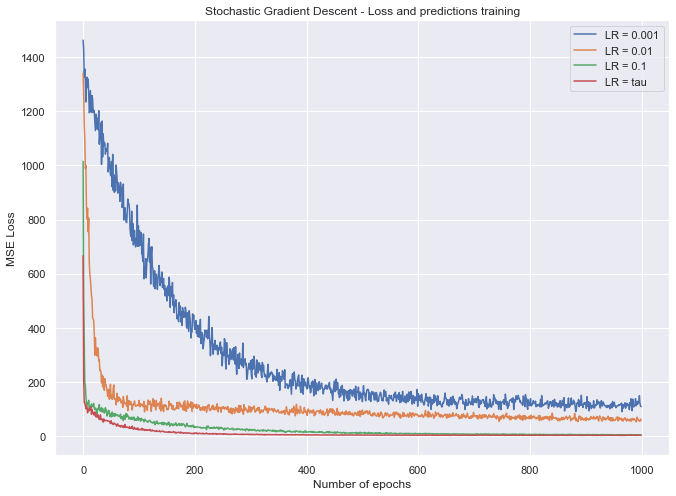

In [110]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_sgd_1, label='LR = 0.001')
plt.plot(range(num_epochs), cost_history_sgd_2, label='LR = 0.01')
plt.plot(range(num_epochs), cost_history_sgd_3, label='LR = 0.1')
plt.plot(range(num_epochs), cost_history_sgd_4, label='LR = 0.5')
plt.plot(range(num_epochs), cost_history_sgd_tau, label='LR = tau')


plt.title('Stochastic Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

In [208]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions_sgd = model(X_test, theta_final_sgd_tau)

In [209]:
coef_sgd = coef_determination(y_test, predictions_sgd)
print(coef_sgd)

0.6863922827435208


Theoretical tests

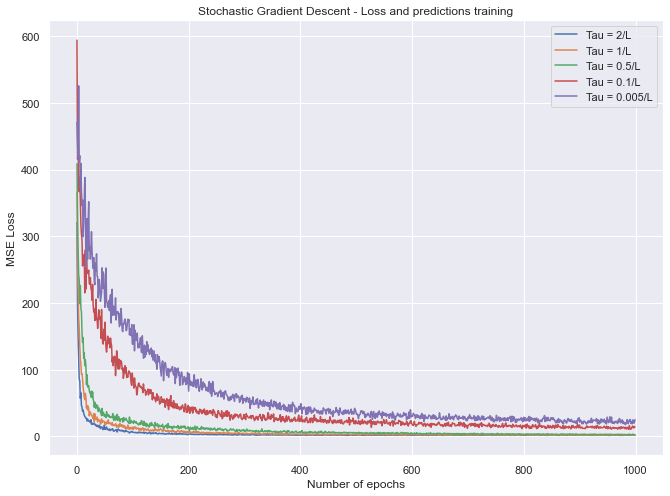

In [109]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_sgd_tau_1, label='Tau = 2/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_2, label='Tau = 1/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_3, label='Tau = 0.5/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_4, label='Tau = 0.1/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_5, label='Tau = 0.005/L')


plt.title('Stochastic Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

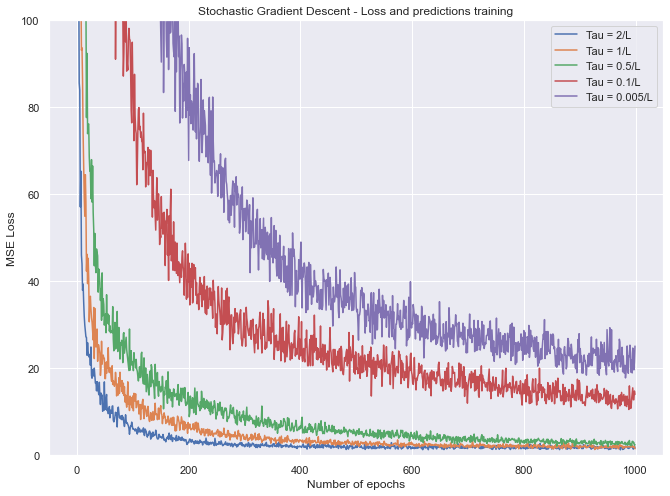

In [110]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_sgd_tau_1, label='Tau = 2/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_2, label='Tau = 1/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_3, label='Tau = 0.5/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_4, label='Tau = 0.1/L')
plt.plot(range(num_epochs), cost_history_sgd_tau_5, label='Tau = 0.005/L')

plt.ylim([0, 100])

plt.title('Stochastic Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison

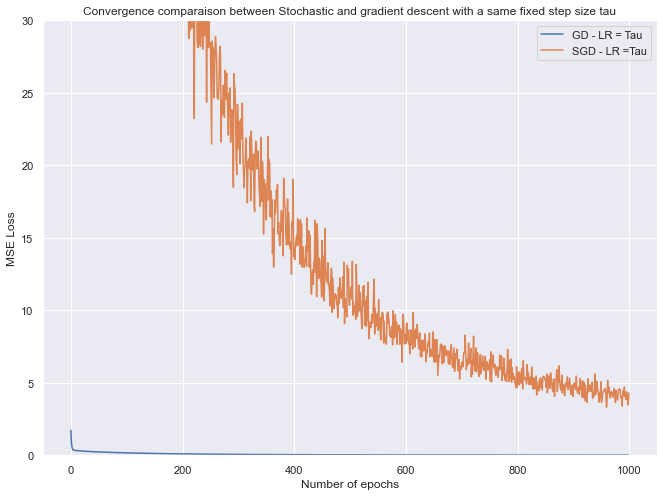

In [115]:
num_epochs = 1000


plt.plot(range(num_epochs), cost_history_3, label='GD - LR = Tau')
plt.plot(range(num_epochs), cost_history_sgd_3, label='SGD - LR =Tau')

plt.ylim([0, 30])

#plt.yticks(np.arange(0, 1000, 100))
#plt.xticks(np.arange(0, 100, 10))

plt.title('Convergence comparaison between Stochastic and gradient descent with a same fixed step size tau')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

### Question 2 -  Batch SG

In [151]:
theta = np.random.randn(15, 1)

In [146]:
theta.shape

(15, 1)

In [152]:
def batch_gradient_descent(X, y, theta,alpha,batch_size, num_iters):

    m = len(y)
    J_history = np.zeros(num_iters)
    n_batches = int(m / batch_size)

    for it in range(num_iters):
        cost = 0.0
        indices = np.random.permutation(m)
        X_ind = X[indices]
        #print(X.shape)
        y_ind = y[indices]
        for i in range(0, m, batch_size):
            X_i = X_ind[i:i + batch_size]
            
            y_i = y_ind[i:i + batch_size]

            X_i = np.c_[np.ones(len(X_i)), X_i]
            #print(X_i.shape)
            #print(X_i)
            h = model(X_i, theta)

        
            theta = theta -  alpha * (1 / m) * ( (X_i.T @ (h - y_i)))
            cost += costFunction(X_i,y_i,theta)
        J_history[it] = cost

    return theta, J_history

In [153]:
m = np.size(y)

theta_final_bsgd_1, cost_history_bsgd_1 = batch_gradient_descent(X_train,y_train,theta,alpha = tau, batch_size = 1, num_iters=1000)
theta_final_bsgd_2, cost_history_bsgd_2 = batch_gradient_descent(X_train,y_train,theta,alpha = tau, batch_size = int(m/100), num_iters=1000)
theta_final_bsgd_3, cost_history_bsgd_3 = batch_gradient_descent(X_train,y_train,theta,alpha = tau, batch_size = int(m/10), num_iters=1000)
theta_final_bsgd_4, cost_history_bsgd_4 = batch_gradient_descent(X_train,y_train,theta,alpha = tau, batch_size = int(m/2), num_iters=1000)
theta_final_bsgd_5, cost_history_bsgd_5 = batch_gradient_descent(X_train,y_train,theta,alpha = tau, batch_size = m, num_iters=1000)

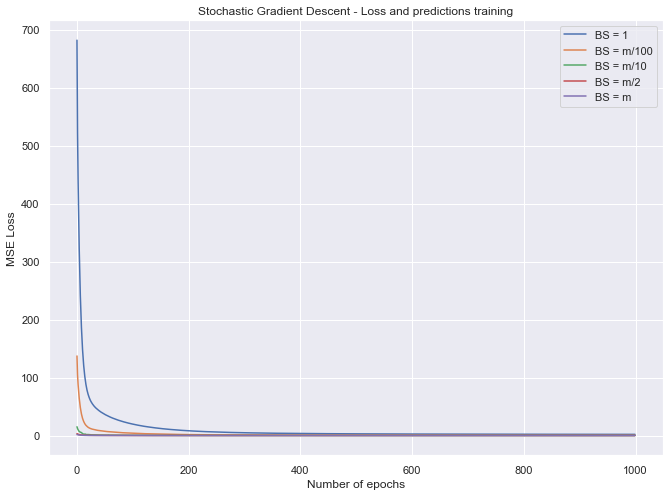

In [154]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_bsgd_1, label='BS = 1')
plt.plot(range(num_epochs), cost_history_bsgd_2, label='BS = m/100')
plt.plot(range(num_epochs), cost_history_bsgd_3, label='BS = m/10')
plt.plot(range(num_epochs), cost_history_bsgd_4, label='BS = m/2')
plt.plot(range(num_epochs), cost_history_bsgd_5, label='BS = m')


plt.title('Stochastic Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

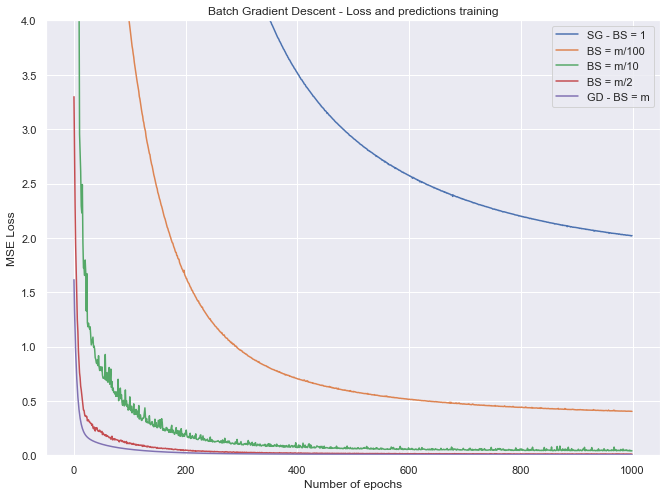

In [155]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_bsgd_1, label='SG - BS = 1')
plt.plot(range(num_epochs), cost_history_bsgd_2, label='BS = m/100')
plt.plot(range(num_epochs), cost_history_bsgd_3, label='BS = m/10')
plt.plot(range(num_epochs), cost_history_bsgd_4, label='BS = m/2')
plt.plot(range(num_epochs), cost_history_bsgd_5, label='GD - BS = m')

plt.ylim([0, 4])

plt.title('Batch Gradient Descent - Loss and predictions training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison

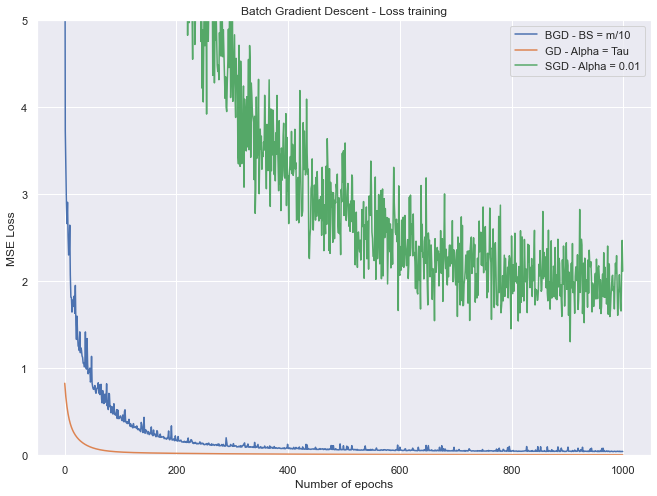

In [119]:
num_epochs = 1000

plt.plot(range(num_epochs), cost_history_bsgd_3, label='BGD - BS = m/10')
plt.plot(range(num_epochs), cost_history_tau, label='GD - Alpha = Tau')
plt.plot(range(num_epochs), cost_history_sgd_tau, label='SGD - Alpha = 0.01')

plt.ylim([0, 5])

plt.title('Batch Gradient Descent - Loss training')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Question 3 - Diagonal Scaling

ADAGRAD

In [127]:
def Adagrad(x, y,theta, alpha, epsoln, num_iters):
   
    m = len(y)
    theta = np.random.randn(X.shape[1]+1, 1)
    cost_array =[0]
    h_theta_array = [0]
    theta_array =[np.zeros(X.shape[1]+1)]
    count = 0
    vt_1 = 0

    for i in range(num_iters):
        

        h_theta = model(x,theta)

        #J_reg = (lamda / (2*m)) * np.sum(np.square(theta))

        gradient = (1/len(y))*(x.T @ (h_theta - y))
        vt = vt_1 + (gradient ** 2)
        theta = (theta - (alpha / (np.sqrt(vt)+epsoln)  * gradient)) 
        cost = ((1/len(y)) * sum((h_theta - y)**2)) 


        theta_array.append(theta)
        cost_array.append(cost)
        h_theta_array.append(h_theta)
        count += 1

    y_pred = x @ theta
    
    return theta_array, cost_array, theta, h_theta_array, y_pred, count

In [128]:
theta_array, cost_array_adagrad, theta_adagrad, h_theta_array, y_pred, count = Adagrad(X_train, y_train,theta, alpha=.001, epsoln = 1e-8, num_iters = 10000)

In [129]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions_adagrad = model(X_test, theta_adagrad)

In [130]:
coef_adagrad = coef_determination(y_test, predictions_adagrad)
print(coef_adagrad)

0.6507958318575559


Text(0, 0.5, 'Cost Function')

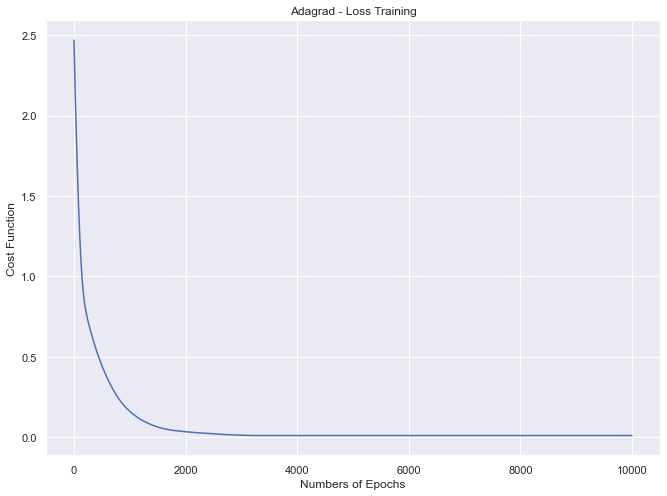

In [131]:
plt.plot(np.arange(count), cost_array_adagrad[1:])
plt.title('Adagrad - Loss Training')
plt.xlabel('Numbers of Epochs')
plt.ylabel('Cost Function')

RMS Prop

In [132]:
def RMSProp(x, y, alpha, theta,epsoln, beta, number_of_iterations):
    
    m = len(y)
    theta = np.random.randn(X.shape[1]+1, 1)
    cost_array =[0]
    h_theta_array = [0]
    theta_array =[np.zeros(X.shape[1]+1)]
    count = 0
    vt_1 = 0

    for i in range(number_of_iterations):
        
        h_theta = model(x,theta)
        #J_reg = (lamda / (2*m)) * np.sum(np.square(theta))


        gradient = (1/len(y))*(x.T @ (h_theta - y))
        vt = (beta * vt_1) + (1-beta)*(gradient ** 2)
        theta = theta - alpha / (np.sqrt(vt)+epsoln)  * gradient
        cost = ((1/len(y)) * sum((h_theta - y)**2))
        
        theta_array.append(theta)
        cost_array.append(cost)
        h_theta_array.append(h_theta)
        count += 1
        
    y_pred = x @ theta
    
    return theta_array, cost_array,h_theta_array,theta, y_pred, count

In [137]:
theta_array, cost_array_rms, h_theta_array, theta_rms, y_pred, count = RMSProp(X_train, y_train, 0.00016,theta,1e-8, .85, 10000)

In [138]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions_rms = model(X_test, theta_rms)

In [139]:
coef_rms = coef_determination(y_test, predictions_rms)
print(coef_rms)

0.69886177075991


Text(0, 0.5, 'Cost Function')

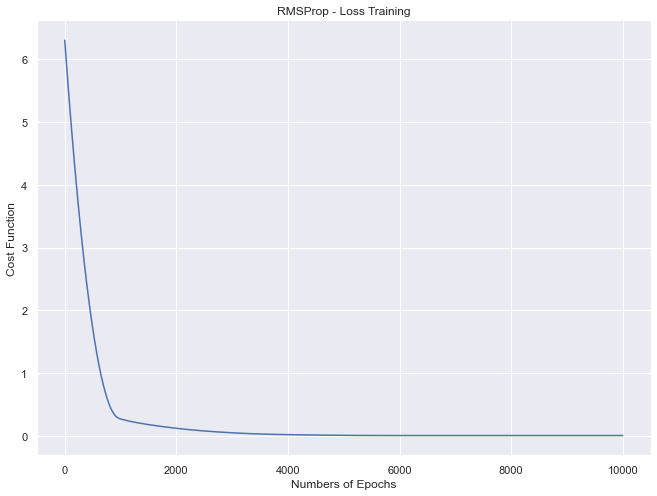

In [140]:
plt.plot(np.arange(count), cost_array_rms[1:])
plt.title('RMSProp - Loss Training')
plt.xlabel('Numbers of Epochs')
plt.ylabel('Cost Function')

In [211]:
def Adam(x, y, alpha,theta,epsoln, beta, gamma, number_of_iterations):
    
    m = len(y)
    theta = np.random.randn(X.shape[1]+1, 1)
    cost_array =[0]
    h_theta_array = [0]
    theta_array =[np.zeros(X.shape[1]+1)]
    count = 0
    vt_1 = 0
    mt_1 = 0

    for i in range(number_of_iterations):
        
        h_theta = model(x,theta)

        gradient = (1/len(y))*(x.T @ (h_theta - y))
        vt = (beta * vt_1) + (1-beta)*(gradient ** 2)
        mt = gamma * mt_1 + (1-gamma) * gradient
        
        vt = vt / (1-beta ** (i+1))
        mt = mt / (1- gamma ** (i+1))
        
        theta = theta - alpha / (np.sqrt(vt)+epsoln)  * mt
        cost = ((1/len(y)) * sum((h_theta - y)**2))
        theta_array.append(theta)
        cost_array.append(cost)
        h_theta_array.append(h_theta)
        count += 1

    y_pred = x @ theta
    
    return theta_array, cost_array,h_theta_array,theta,y_pred, count

In [215]:
theta_array, cost_array_adam,h_theta_array,theta_adam,y_pred, count = Adam(X_train, y_train, .001,theta, 1e-8, .98, .9, 10000)

In [216]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions_adam = model(X_test, theta_adam)

In [217]:
coef_adam = coef_determination(y_test, predictions_adam)
print(coef_adam)

0.6857377359654502


Text(0, 0.5, 'Cost Function')

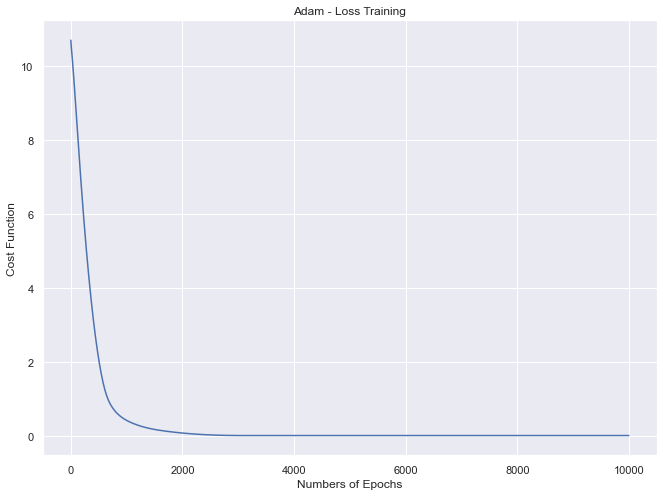

In [218]:
plt.plot(np.arange(count), cost_array_adam[1:])
plt.title('Adam - Loss Training')
plt.xlabel('Numbers of Epochs')
plt.ylabel('Cost Function')

Comparaison ADAGRAD / SG / RMSPROP

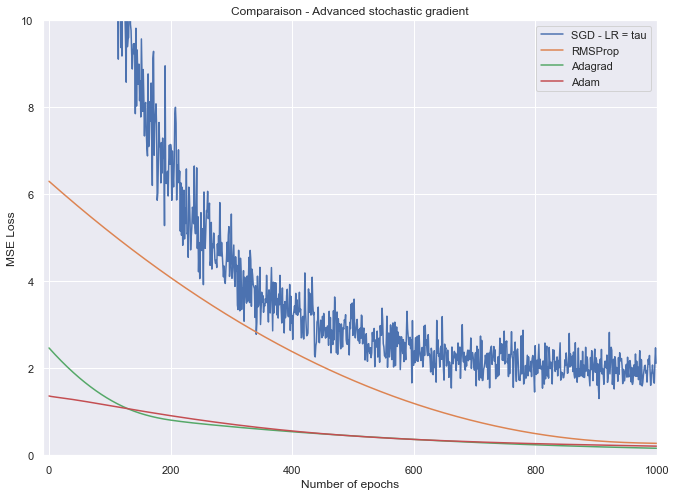

In [155]:
num_epochs = 1000

plt.plot(range(num_epochs), cost_history_sgd_tau, label='SGD - LR = tau')
plt.plot(np.arange(count), cost_array_rms[1:], label = "RMSProp")
plt.plot(np.arange(count), cost_array_adagrad[1:], label='Adagrad')
plt.plot(np.arange(count), cost_array_adam[1:], label = "Adam")

plt.ylim([0, 10])
plt.xlim([-10,1000])

plt.title('Comparaison - Advanced stochastic gradient')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

[0.6507958318575559, 0.69886177075991, 0.6857377359654502, 0.6863922827435208]


Text(0.5, 1.0, 'Bar plot of Coefficient Determination Value for differents values of Lamdas')

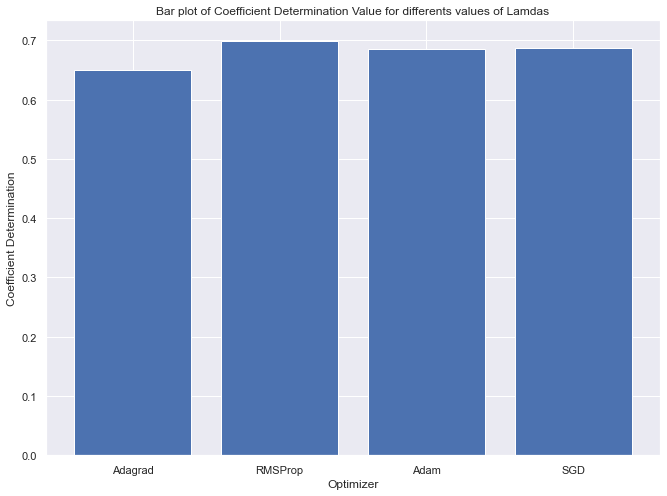

In [219]:
liste_coeff_sgd_variants = [coef_adagrad,coef_rms,coef_adam,coef_sgd]
print(liste_coeff_sgd_variants)
names = ['Adagrad', 'RMSProp', 'Adam','SGD'] # nom des barres

values = liste_coeff_sgd_variants 

plt.bar(names, values)
plt.xlabel("Optimizer")
plt.ylabel("Coefficient Determination")
plt.title("Bar plot of Coefficient Determination Value for differents values of Lamdas")

# Partie 4 - Convexity and constrained optimization

Convex optimization problem represented by a quadratic function + affine constraints

- Frank Wolfe + simplexe/interior points solver
- Projected gradient with L1-Ball 
- Augmented Lagrangian

Tests and comparaison Projected Gradient VS Conditionnal Gradient

In [156]:
from collections import deque

In [157]:
class LineSearchOptimizer(object):

    '''
    Class contains all functions dedicated to build the optimizer
    '''

    def __init__(self, f, grad, step_size, memory_size=1, **kwargs):
        self.convergence = []
        self._f = f
        self._grad = grad
        if step_size is not None:
            step_size.assign_function(f, grad, self._f_update_x_next)
        self._step_size = step_size
        self._par = kwargs
        self._grad_mem = deque(maxlen=memory_size)
        
        
    def get_convergence(self):
        return self.convergence
    
    def solve(self, x0, max_iter=100, tol=1e-6, disp=False):
        self.convergence = []
        self._x_current = x0.copy()
        self.convergence.append(self._x_current)
        iteration = 0
        self._current_grad = None
        while True:
            self._h = self.get_direction(self._x_current)
            if self._current_grad is None:
                raise ValueError("Variable self._current_grad has to be initialized in method get_direction()!")
            self._grad_mem.append(self._current_grad)
            if disp > 1:
                print("Iteration {}/{}".format(iteration, max_iter))
                print("Current function val =", self._f(self._x_current))
                self._print_info()
            self._alpha = self.get_stepsize()
            self._update_x_next()
            self._update_x_current()
            self._append_conv()
            iteration += 1
            if iteration >= max_iter:
                if disp > 0:
                    print("Maximum iteration exceeds!")
                break
        if disp:
            print("Convergence in {} iterations".format(iteration))
            print("Function value = {}".format(self._f(self._x_current)))
            self._print_info()
        return self._get_result_x()
    
    def get_direction(self, x):
        raise NotImplementedError("You have to provide method for finding direction!")
        
    def _update_x_current(self):
        self._x_current = self._x_next
        
    def _update_x_next(self):
        self._x_next = self._f_update_x_next(self._x_current, self._alpha, self._h)
        
    def _f_update_x_next(self, x, alpha, h):
        return x + alpha * h
        
    def check_convergence(self, tol):
        return np.linalg.norm(self._current_grad) < tol
        
    def get_stepsize(self):
        raise NotImplementedError("You have to provide method for finding step size!")
    
    def _print_info(self):
        print("Norm of gradient = {}".format(np.linalg.norm(self._current_grad)))
    
    def _append_conv(self):
        self.convergence.append(self._x_next)
        
    def _get_result_x(self):
        return self._x_current

In [169]:
class StepSize(object):
    '''
    Base class for all classes for defining step size
    '''
    def __init__(self):
        pass
    def get_stepsize(self, *args, **kwargs):
        raise NotImplementedError("Method to get current step size has to be implemented!")
        
    def assign_function(self, f, grad, *args):
        pass

In [1]:
class Backtracking(StepSize):
    '''
    Class represents rule for backtracking search of step size
    '''
    def __init__(self, rule_type, **kwargs):
        self.rule = rule_type
        self.par = kwargs
        if self.rule == "Lipschitz" and "eps" not in self.par:
            self.par["eps"] = 0.
        if "disp" not in self.par:
            self.par["disp"] = False
        if self.rule == "Lipschitz":
            self._alpha = None
    
    def assign_function(self, f, grad, update_x_next):
        self._f = f
        self._grad = grad
        self._update_x_next = update_x_next
    
    def get_stepsize(self, h, x, num_iter, *args):
        alpha = self.par["init_alpha"]
        if self.rule == "Armijo":
            rho = self.par["rho"]
            beta = self.par["beta"]
            assert beta < 0.5, "Armijo rule is applicable for beta less than 0.5"
            assert rho < 1, "Decay factor has to be less than 1"
            current_grad = self._grad(x)
            current_f = self._f(x)
            x_next = self._update_x_next(x, alpha, h)
            while True:
                if np.isnan(self._f(x_next)):
                    alpha *= rho
                else:
                    if self._f(x_next) >= current_f + beta * current_grad.dot(x_next - x):
                        alpha *= rho
                    else:
                        break
                if alpha < 1e-16:
                    raise ValueError("Step size is too small!")
                x_next = self._update_x_next(x, alpha, h)
            return alpha

NameError: name 'StepSize' is not defined

In [171]:
class FrankWolfe(LineSearchOptimizer):
    
    '''
    Class represents conditional gradient descent method aka Frank Wolfe algorithm
    '''
    
    def __init__(self, f, grad, linsolver, step_size):
        super().__init__(f, grad, step_size)
        self._linsolver = linsolver
        self._h = None
        
    def get_direction(self, x):
        s = self._linsolver(self._grad(x))
        self._current_grad = self._grad(x)
        self._h = s - x
        return self._h
    
    def check_convergence(self, tol):
        if len(self.convergence) == 1:
            return False
        if self._f(self.convergence[-2]) - self._f(self.convergence[-1]) < tol:
            return True
        else:
            return False
        
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._h, self.convergence[-1], len(self.convergence))
    
    def _print_info(self):
        print("Difference in function values = {}".format(self._f(self.convergence[-2]) - self._f(self.convergence[-1])))
        print("Difference in argument = {}".format(np.linalg.norm(self.convergence[-1] - self.convergence[-2])))

In [172]:
import numpy as np

class ProjectedGD(LineSearchOptimizer):
    
    '''
    Class represents projected gradient method
    '''
    
    def __init__(self, f, grad, projector, step_size):
        super().__init__(f, grad, step_size)
        self._projector = projector
        
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad
    
    def _f_update_x_next(self, x, alpha, h):
        return self._projector(x + alpha * h)
    
    def check_convergence(self, tol):
        if len(self.convergence) == 1:
            return False
        if self._f(self.convergence[-2]) - self._f(self.convergence[-1]) < tol:
            return True
        else:
            return False
        
    def get_stepsize(self):
        return self._step_size.get_stepsize(-self._grad_mem[-1], self.convergence[-1], len(self.convergence))
    
    def _print_info(self):
        print("Difference in function values = {}".format(self._f(self.convergence[-2]) - self._f(self.convergence[-1])))
        print("Difference in argument = {}".format(np.linalg.norm(self.convergence[-1] - self.convergence[-2])))

Test 1 

In [173]:
def func(x, A, b):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2

f = lambda x: func(x, A, b)

def grad_f(x, A, b):
    grad = -A.T.dot(b)
    grad = grad + A.T.dot(A.dot(x))
    return grad

grad = lambda x: grad_f(x, A, b)

In [174]:
def linsolver(gradient):
    x = np.zeros(gradient.shape[0])
    positive_grad = gradient > 0
    negative_grad = gradient < 0
    x[positive_grad] = np.zeros(np.sum(positive_grad == True))
    x[negative_grad] = np.ones(np.sum(negative_grad == True))
    return x

In [175]:
def projection(y):
    return np.clip(y, 0, 1)

In [176]:
import numpy as np
from tqdm import tqdm

n = 200
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true) + 0.01 * np.random.randn(m)

In [177]:
def myplot(x, y, xlab, ylab, xscale="linear", yscale="log"):
    plt.figure(figsize=(10, 8))
    plt.xscale(xscale)
    plt.yscale(yscale)
    for key in y:
        plt.plot(x[key], y[key], label=key)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="best", fontsize=24)
    plt.xlabel(xlab, fontsize=24)
    plt.ylabel(ylab, fontsize=24)

In [178]:
x0 = np.random.rand(n)
cg = FrankWolfe(f, grad, linsolver, Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
x_cg = cg.solve(x0=x0, max_iter=200, tol=1e-10, disp=1)
print("Optimal value CG =", f(x_cg))



Required tolerance achieved!
Convergence in 196 iterations
Function value = 1.6314462912180243e-09
Difference in function values = 7.439496568963814e-11
Difference in argument = 2.750411767801779e-06
Optimal value CG = 1.6314462912180243e-09


In [179]:
pg = ProjectedGD(f, grad, projection, Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
x_pg = pg.solve(x0=x0, max_iter=200, tol=1e-10, disp=1)
print("Optimal value PG =", f(x_pg))

Required tolerance achieved!
Convergence in 68 iterations
Function value = 1.1441448845485182e-10
Difference in function values = 2.2480186084394873e-11
Difference in argument = 1.2646607235409719e-06
Optimal value PG = 1.1441448845485182e-10


In [180]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=False)
y_hist_f_cg = [f(x) for x in cg.get_convergence()]
y_hist_f_pg = [f(x) for x in pg.get_convergence()]

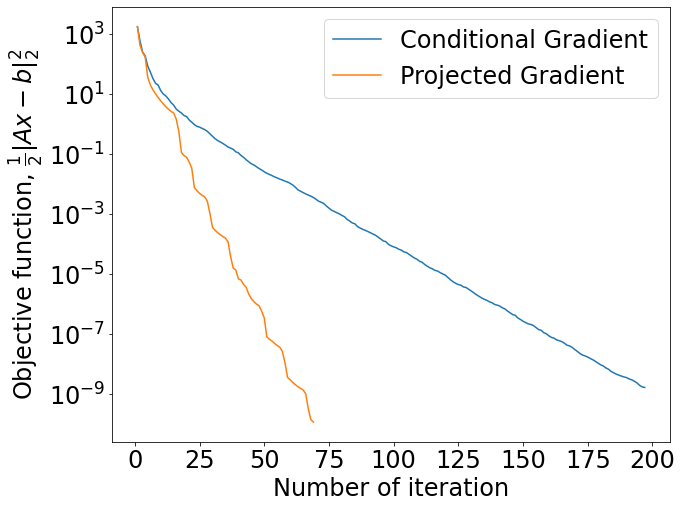

In [182]:
myplot({"Conditional Gradient": range(1, len(y_hist_f_cg) + 1), "Projected Gradient": range(1, len(y_hist_f_pg) + 1)},
       {"Conditional Gradient": y_hist_f_cg, "Projected Gradient": y_hist_f_pg}, "Number of iteration",
       r"Objective function, $\frac{1}{2}\|Ax - b\|^2_2$")

Test 2

In [183]:
def linsolver(gradient):
    x = np.zeros(gradient.shape[0])
    idx_min = np.argmin(gradient)
    if gradient[idx_min] > 0:
        x[idx_min] = 0
    else:
        x[idx_min] = 1
    return x

In [190]:
def projection_l1(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x = np.clip(x, 0, np.max(x))
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    t_hat = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [191]:
x0 = np.random.rand(n) * 10
x0 = x0 / x0.sum()
cg = FrankWolfe(f, grad, linsolver, Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
x_cg = cg.solve(x0=x0, max_iter=200, tol=1e-10)
print("Optimal value CG =", f(x_cg))

Optimal value CG = 4235.32285464132


In [193]:
pg_l1 = ProjectedGD(f, grad, projection_l1, Backtracking(rule_type="Armijo", rho=0.5, beta=0.1, init_alpha=1.))
x_pg_l1 = pg_l1.solve(x0=x0, max_iter=200, tol=1e-10)
print("Optimal value PG_l1 =", f(x_pg_l1))

Optimal value PG_l1 = 4235.322854482816


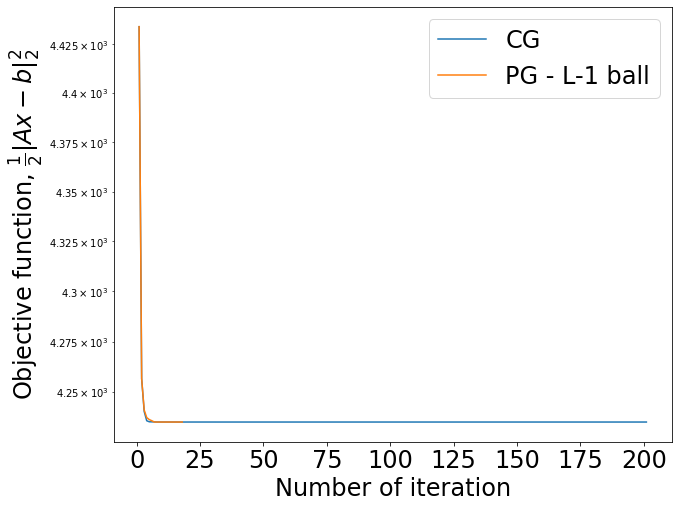

In [194]:
y_hist_f_cg = [f(x) for x in cg.get_convergence()]
y_hist_f_pg = [f(x) for x in pg_l1.get_convergence()]
myplot({"CG": range(1, len(y_hist_f_cg) + 1), "PG - L-1 ball": range(1, len(y_hist_f_pg) + 1)},
       {"CG": y_hist_f_cg, "PG - L-1 ball": y_hist_f_pg}, "Number of iteration",
       r"Objective function, $\frac{1}{2}\|Ax - b\|^2_2$")

Test Conditional gradient algorithm 

In [138]:
from scipy.optimize import linprog
import numdifftools as nd
import numpy as np
import time

class frank_wolfe():
    
    def __init__(self,min_fun,A,b,bounds,x0,iterations=100):
        self.min_fun = min_fun
        self.A = A
        self.b = b
        self.bounds = bounds
        self.x0 = x0
        self.iterations = iterations
        self.x_min = []
        self.f_min = 0
        self.x_t = []
        self.s_t = []
        self.f_t = []
        self.violation = 0
        self.time = 0
        
    def __repr__(self):
        out = 'f_min: '+str(self.f_min)+'\n' + \
                'x_min: '+str(self.x_min)+'\n' + \
                'violation: '+str(self.violation)+'\n' + \
                'time: '+str(self.time)
        return out

    def optimize_simplex(self):
        x = self.x0
        t1 = time.time()
        for i in range(0,self.iterations):
            gamma = 2 / (i+2)
            grad_def = nd.Gradient(self.min_fun)
            grad = grad_def(x)
            update = linprog(grad, A_ub=self.A, b_ub=self.b, A_eq=None, b_eq=None, bounds=self.bounds, 
                 method='highs', callback=None, x0=None, #highs method by default equivalent to simplex method
                 options={'sym_pos':False,'lstsq':True})

            s = update.x
            self.s_t.append(s)
            x = x + gamma*(s-x)
            self.f_t.append(self.min_fun(x))
            self.x_t.append(x)
        t2 = time.time()
        self.time = t2 - t1
        
        constraints = np.dot(self.A,x) - self.b
        self.violation = np.sum([i for i in constraints if i > 0])
        self.x_min = x
        self.f_min = self.f_t[-1]
        return self

In [139]:
def min_fun(x):
    """The function to minimize"""
    return 11*(x[0]-1)**2 + x[1]**2 + 0.3*x[2]**2 + 2*x[0]*x[1] - x[0]*x[2] - 4*x[0] + 11*x[1]

In [140]:
from scipy.optimize import minimize,LinearConstraint,Bounds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# number of constraints and variables
constr_num = 4
var_num = 3

#random A
A = np.random.randint(-10,10, (constr_num,var_num))
ub = 10*np.ones(constr_num)

# 0 <= x_i <= 1
bounds=[(0,1) for i in range(0,var_num)]
# Initial point x0
x0 = np.random.randint(0,10,(var_num))


# Use Frank-Wolfe
iterations = 400
fw = frank_wolfe(min_fun,A,ub,bounds,x0,iterations)
#results_interior_point = fw.optimize()
results_simplex = fw.optimize_simplex()

# Use a convex solver
bounds = Bounds(np.zeros(var_num), 10*np.ones(var_num))
lb = -np.inf*np.ones(constr_num)
linear_constraint = LinearConstraint(A, lb, ub)

res = minimize(min_fun, x0, method='trust-constr', jac=nd.Gradient(min_fun),
                constraints=linear_constraint, bounds=bounds,
                options={'verbose': 0,'bound': 1e-8, 'disp': True})

# Optimality gap for every optimization technique

#f_star_interior_points = [res.fun for i in range(0,len(results_interior_point.f_t))]

`gtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 19, CG iterations: 37, optimality: 7.77e-09, constraint violation: 0.00e+00, execution time: 0.034 s.


In [134]:
f_star_simplex = [res.fun for i in range(0,len(results_simplex.f_t))]

Interior point method

C:\Users\adrie\AppData\Local\Temp\ipykernel_25260\164468314.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(0,iterations), np.abs(np.array(f_star_interior_points) - np.array(results_interior_point.f_t)),'bo-',lw=2,color='green')


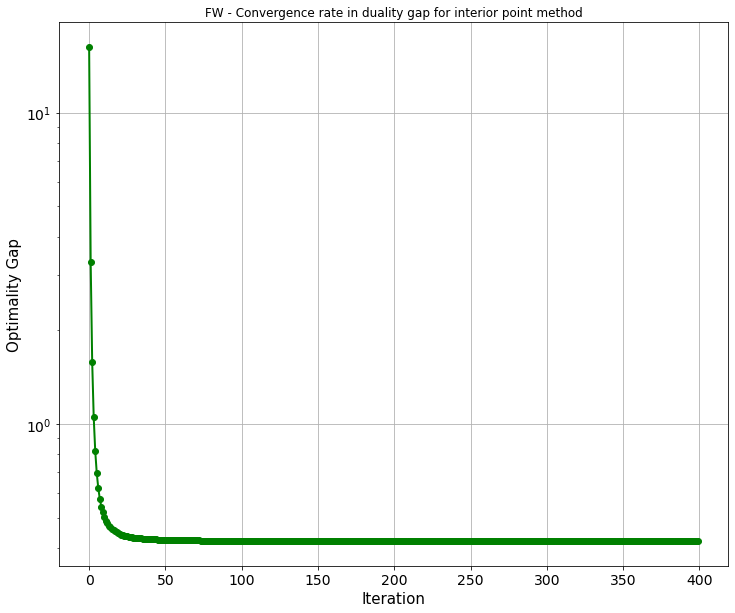

In [141]:
fig = plt.figure(figsize = (12, 10))
plt.yscale('log')
plt.grid()

plt.plot(range(0,iterations), np.abs(np.array(f_star_interior_points) - np.array(results_interior_point.f_t)),'bo-',lw=2,color='green')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Optimality Gap',fontsize=15)
plt.xlabel('Iteration',fontsize=15)
plt.title("FW - Convergence rate in duality gap for interior point method")
plt.show()

#### Simplex method

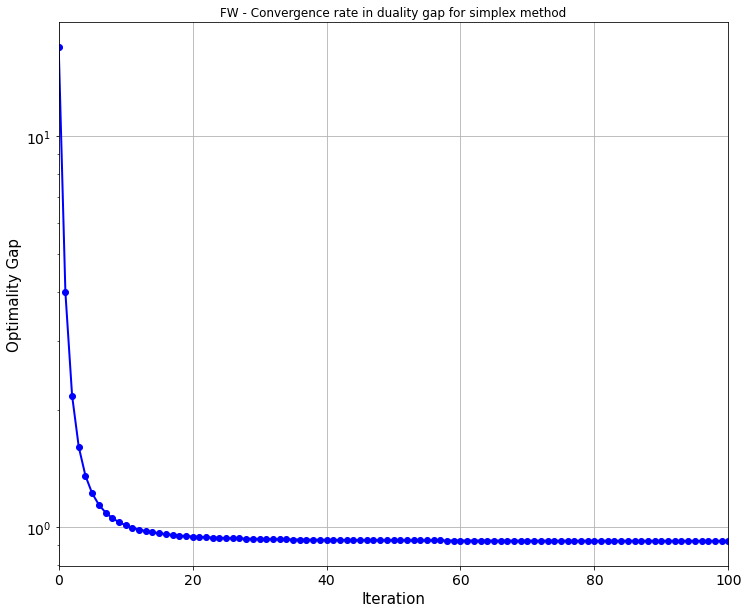

In [137]:
fig = plt.figure(figsize = (12, 10))
plt.yscale('log')
plt.grid()

plt.plot(range(0,iterations), np.abs(np.array(f_star_simplex) - np.array(results_simplex.f_t)),'bo-',lw=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Optimality Gap',fontsize=15)

plt.xlabel('Iteration',fontsize=15)
plt.xlim([0, 100])

plt.title("FW - Convergence rate in duality gap for simplex method")
plt.show()

#### Augmented Lagrangian method

In [156]:
%matplotlib inline
from __future__ import division, print_function, absolute_import


import numpy as np
from scipy.optimize import fmin_bfgs

# some global constants
_epsilon = np.sqrt(np.finfo(float).eps) # the float number accuracy

msg = "test"

In [157]:
def calculate_vecnorm(x, order = 2):
    """
    Calculate the norm of a vector `x` given the norm order.
    """
    if type(x) == np.ndarray:
        if order == np.Inf:
            return np.amax(np.abs(x))
        elif order == -np.Inf:
            return np.amin(np.abs(x))
        else:
            return np.sum(np.abs(x)**order, axis = 0)**(1.0/order)
    else:
        print("x is not a numpy ndarray!")
        exit(-1)


def wrap_function(function, args):
    ncalls = [0]
    if function is None:
        return ncalls, None

    def function_wrapper(*wrapper_args):
        ncalls[0] += 1 # record the number of times that the function is called.
        return function(*(wrapper_args + args))

    return ncalls, function_wrapper

# Lagrangian function
def Augmented_LagrangianMfunc(x, objFun, conFuns, w, v, Penality_factor):

    ineqConFuns, eqConFuns = conFuns(x)
    sumValue1 = np.sum([(np.max([0,wi-Penality_factor*ineqi]))**2 - wi**2 for wi, ineqi in zip(w, ineqConFuns)])
    sumValue2 = np.sum([0.5*Penality_factor*((eqj)**2)-vj*eqj for vj, eqj in zip(v, eqConFuns)])
    return objFun(x) + sumValue1/(2.*Penality_factor) + sumValue2

In [149]:
def fmin_Augmented_LagrangianM(objFun, x0, conFuns, NbEquations_Constr, inNbEquations_Constr, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
bound= 1e-5, Penality_factor = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):

    res = _fmin_ALM(objFun, x0, conFuns, NbEquations_Constr, inNbEquations_Constr, \
    funArgs, conArgs, multiplierRange,\
    bound, Penality_factor, beta, alpha, \
    norm, epsilon, maxiter, full_output, \
    disp, retall, callback)

    if full_output:
        retlist = (res['x'], res['fun'],\
                   res['nfev'], res['nconev'], res['status'], res['message'],\
                   res['nit'])
        if retall:
            retlist += (res['allvecs'], )
        return retlist
    else:
        if retall:
            return res['x'], res['allvecs']
        else:
            return res['x']



#optimization problem transformed into an unconstrained optimization formulation
def _fmin_ALM(objFun, x0, conFuns, NbEquations_Constr, ineqConNum, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
bound = 1e-5, Penality_factor = 3.0, beta = 0.8, alpha = 1.2, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):
 
    x0 = np.asarray(x0).flatten()
    if x0.ndim == 0:
        x0.shape = (1,)
    if maxiter is None:
        maxiter = len(x0)*200
    opts = {'bound':bound, 
            'norm':norm,
            'epsilon':epsilon, 
            'maxiter':maxiter, 
            'full_output':1, 
            'disp':0,
            'retall':1, }
            
    func_calls, f = wrap_function(objFun, funArgs) # f is callable, i.e., f(x)
    conFunc_calls, conF = wrap_function(conFuns, conArgs) # conf in each list returned by conF(x) is callable
    allvecs = []
    
    gnorm = 1
    fval = f(x0)
    k = 0
    if retall:
        allvecs.append((x0, fval))
    
    # randomly initialize the multiplers corresponding to each constraint
    # which is within [0.1,1.0]
    if ineqConNum == 0:
        wk = np.array([])
    else:
        wk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(ineqConNum)
    if NbEquations_Constr == 0:
        vk = np.array([])
    else:
        vk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(NbEquations_Constr)
        
    xk_1 = x0
    warnflag = 0

    while (gnorm > bound) and (k < maxiter):

        # step 1:
        # construct the augmented Lagrangian function
        ALfun = lambda x : Augmented_LagrangianMfunc(x, f, conF, wk, vk, Penality_factor)

         # step 2:
        # Solve the unconstrained problem for x
        
        res = fmin_bfgs(ALfun, xk_1, fprime=None, args=(), **opts)


        
        xk = res[0]
        if callback is not None:
            callback(xk)

            
        gnorm = calculate_vecnorm(conF(xk)[1], order=norm)
        fval = f(xk)

        # step 3:
        # check whether the constraints are respected
        if gnorm < bound:
            break
        # check the objective value
        if not np.isfinite(fval):
            warnflag = 2
            break
        if retall:
            allvecs.append((xk, fval))
            
        # step 4:
        # adapt the convergence speed.
        den = calculate_vecnorm(conF(xk_1)[1], order=norm)
        if (den != 0) and (gnorm/den >= beta):
            # increase the penality factor
            Penality_factor = alpha*Penality_factor
        # step 5:
        # Update the multipliers: wk and vk
        _updateMultipliers(xk, wk, vk, Penality_factor, conF)
        k += 1
        xk_1 = xk  
                
    result = OptimizeResult(fun=fval, nfev=func_calls[0], nconev=conFunc_calls[0],\
                            status=warnflag, success=(warnflag == 0), message=msg,\
                            x=xk, nit=k)
    if retall:
        result['allvecs'] = allvecs
    return result
        
        
def _updateMultipliers(xk, wk, vk, Penality_factor, conF):
    ineqCons, eqCons = conF(xk)
    i = 0
    for wk_i, ineq_i in zip(wk, ineqCons):
        wk[i] = np.max([0, wk_i-Penality_factor*ineq_i])
        i += 1
    j = 0
    for vk_j, eq_j in zip(vk, eqCons):
        vk[j] = vk_j - Penality_factor*eq_j
        j += 1

def testObjFun(x, parameters):

    return np.sum([(xi - parai)**2 for xi, parai in zip(x, parameters)])
    

#Update of the equalities/inequalities dictionnaries
def testConFun(x, parameters):

    ineqConsArray = []
    eqConsArray = []
    for keyStr, paraList in parameters.items():
        if keyStr == 'ineq':
            for paraTuple in paraList:
                ineqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        elif keyStr == 'eq':
            for paraTuple in paraList:
                eqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        else:
            print("The parameter dictionary of the constraints does not contain \
            the key '%s'!"%keyStr)
            exit(-1)
    return np.asarray(ineqConsArray, dtype=np.float), np.asarray(eqConsArray, dtype=np.float)

In [159]:
def fmin_Augmented_LagrangianM(objFun, x0, conFuns, NbEquations_Constr, inNbEquations_Constr, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
bound = 1e-5, Penality_factor = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):

    res = _fmin_ALM(objFun, x0, conFuns, NbEquations_Constr, inNbEquations_Constr, \
    funArgs, conArgs, multiplierRange,\
    bound, Penality_factor, beta, alpha, \
    norm, epsilon, maxiter, full_output, \
    disp, retall, callback)

    if full_output:
        retlist = (res['x'], res['fun'],\
                   res['nfev'], res['nconev'], res['status'], res['message'],\
                   res['nit'])
        if retall:
            retlist += (res['allvecs'], )
        return retlist
    else:
        if retall:
            return res['x'], res['allvecs']
        else:
            return res['x']


def _fmin_ALM(objFun, x0, conFuns, eqConNum, ineqConNum, \
funArgs = (), conArgs = (), multiplierRange = (0.1, 1.0),\
bound = 1e-5, Penality_factor = 3.0, beta = 0.7, alpha = 1.2, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 0, \
disp = 1, retall = 0, callback = None):

    x0 = np.asarray(x0).flatten()
    if x0.ndim == 0:
        x0.shape = (1,)
    if maxiter is None:
        maxiter = len(x0)*200
    opts = {'bound':bound, 
            'norm':norm,
            'epsilon':epsilon, 
            'maxiter':maxiter, 
            'full_output':1, 
            'disp':0,
            'retall':1, 
            'callback':None}
            
    func_calls, f = wrap_function(objFun, funArgs) # f is callable, i.e., f(x)
    conFunc_calls, conF = wrap_function(conFuns, conArgs) # conf in each list returned by conF(x) is callable
    allvecs = []
    
    gnorm = 1
    fval = f(x0)
    k = 0
    if retall:
        allvecs.append((x0, fval))
    
    # randomly initialize the multiplers corresponding to each constraint
    # which is within [0.1,1.0]
    if ineqConNum == 0:
        wk = np.array([])
    else:
        wk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(ineqConNum)
    if eqConNum == 0:
        vk = np.array([])
    else:
        vk = multiplierRange[0] + (multiplierRange[1] \
        - multiplierRange[0])*np.random.rand(eqConNum)
        
    xk_1 = x0
    warnflag = 0
    if callback is not None:
        callback(xk_1)
    while (gnorm > bound) and (k < maxiter):
        # step 1:
        # construct the augmented Lagrangian function
        ALfun = lambda x : Augmented_LagrangianMfunc(x, f, conF, wk, vk, sigma)
        
        # step 2:
        # Solve the unconstrained problem for x
        try:
            res = fmin_bfgs(ALfun, xk_1, fprime=None, args=(), **opts)
            if disp:
                print("The status of the %i-th unconstrained optimization: %s"%(k, res[6]))
        except _UnconstrainedOptimizationError:
            warnflag = 2
            break
        
        xk = res[0]
        if callback is not None:
            callback(xk)
            
        gnorm = calculate_vecnorm(conF(xk)[1], order=norm)
        fval = f(xk)
        # step 3:
        # check whether the global tolerance is satisfied.
        if gnorm < bound:
            print("""The equality constraint norm evaluated at x[%i] is less than the global tolerance!"""%k)
            break
        # check the objective value
        if not np.isfinite(fval):
            print("""The function value evaluated at x[%i] is infinite! Something may go wrong!"""%k)
            warnflag = 2
            break
        if retall:
            allvecs.append((xk, fval))
            
        # step 4:
        # adapt the convergence speed.
        den = calculate_vecnorm(conF(xk_1)[1], order=norm)
        if (den != 0) and (gnorm/den >= beta):
            # increase the penalty factor
            sigma = alpha*sigma
        
        # step 5:
        # Update the multipliers: wk and vk
        _updateMultipliers(xk, wk, vk, Penality_factor, conF)
        k += 1
        xk_1 = xk  

        
def _updateMultipliers(xk, wk, vk, sigma, conF):
    ineqCons, eqCons = conF(xk)
    i = 0
    for wk_i, ineq_i in zip(wk, ineqCons):
        wk[i] = np.max([0, wk_i-sigma*ineq_i])
        i += 1
    j = 0
    for vk_j, eq_j in zip(vk, eqCons):
        vk[j] = vk_j - sigma*eq_j
        j += 1
        
def testObjFun(x, parameters):

    return np.sum([(xi - parai)**2 for xi, parai in zip(x, parameters)])
    
def testConFun(x, parameters):

    ineqConsArray = []
    eqConsArray = []
    for keyStr, paraList in parameters.items():
        if keyStr == 'ineq':
            for paraTuple in paraList:
                ineqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        elif keyStr == 'eq':
            for paraTuple in paraList:
                eqConsArray.append(paraTuple[0]*x[0]+paraTuple[1]*x[1]+paraTuple[2])
        else:
            print("The parameter dictionary of the constraints does not contain \
            the key '%s'!"%keyStr)
            exit(-1)
    return np.asarray(ineqConsArray, dtype=np.float), np.asarray(eqConsArray, dtype=np.float)

C:\Users\adrie\AppData\Local\Temp\ipykernel_14300\1737415397.py:280: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.asarray(ineqConsArray, dtype=np.float), np.asarray(eqConsArray, dtype=np.float)


f(x[0]) = 1
f(x[0]) = 2
g0(x[0]) = 2.0 >= 0
g1(x[0]) = 0.0 >= 0
h0(x[0]) = 0.0 = 0
------Begin testing------
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that of the corresponding constraints!
The multiplier number is not equal to that o

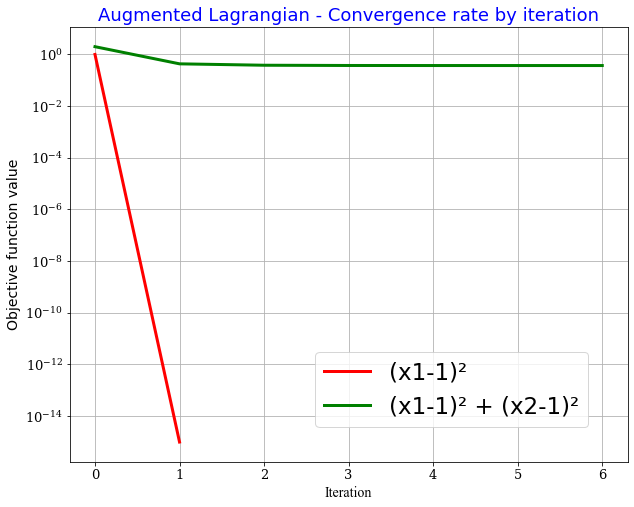

In [165]:
import time

x0 = np.array([2, 0])

funParameters_1 = np.array([1])
funParameters_2 = np.array([1,1])

#x1 et x2 > 0
ineqParameters = [(1, 0, 0), (0, 1, 0)]
#eqParameters = nothing
conParaDict = {'ineq':ineqParameters, 'eq':eqParameters}


# evaluate the function as well as the constraint functions at the initial point
fval1 = testObjFun(x0, funParameters_1)
fval2 = testObjFun(x0, funParameters_2)

ineqVals, eqVals = testConFun(x0, conParaDict)
print("f(x[0]) = %s"%fval1)
print("f(x[0]) = %s"%fval2)
for ineqIndex in range(len(ineqVals)):
    print("g%i(x[0]) = %s >= 0"%(ineqIndex, ineqVals[ineqIndex]))
for eqIndex in range(len(eqVals)):
    print("h%i(x[0]) = %s = 0"%(eqIndex, eqVals[eqIndex]))


print("------Begin testing------") 
retall = 1
bt = time.time()


#Two differents problems
res_1 = fmin_Augmented_LagrangianM(testObjFun, x0, testConFun, NbEquations_Constr = 1, inNbEquations_Constr= 5, \
    
funArgs = (funParameters_1,), conArgs = (conParaDict,), multiplierRange = (0.1, 1.0),\
bound = 1e-5, Penality_factor = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 1, \
disp = 0, retall = retall, callback = None)

res_2 = fmin_Augmented_LagrangianM(testObjFun, x0, testConFun, NbEquations_Constr = 1, inNbEquations_Constr = 5, \
    
funArgs = (funParameters_2,), conArgs = (conParaDict,), multiplierRange = (0.1, 1.0),\
bound = 1e-5, Penality_factor = 3.0, beta = 0.9, alpha = 1.3, \
norm = 2, epsilon = _epsilon, maxiter = None, full_output = 1, \
disp = 0, retall = retall, callback = None)

if retall:
    import matplotlib.pyplot as plt
    plt.figure(0, figsize=(10,8))


    plt.plot([xf[1] for xf in res_1[-1]], linewidth = 3.0, \
    color='red', linestyle='-', \
    markersize = 20, fillstyle='none',   label = '(x1-1)²')
    
    
    plt.plot([xf[1] for xf in res_2[-1]], linewidth = 3.0, \
    color='green', linestyle='-', \
    markersize = 20, fillstyle='none',   label = '(x1-1)² + (x2-1)²')
    
    plt.yscale('log')
    plt.title('Augmented Lagrangian - Convergence rate by iteration', fontsize=18, color='b')
    plt.xlabel('Iteration', fontsize=14, fontname='Times New Roman')
    plt.ylabel('Objective function value', fontsize=14)
    
    legendfont = {"size":23}        
    plt.legend(prop=legendfont,bbox_to_anchor=(0.95,0.28))
    plt.xticks(fontsize=13, fontname='serif')
    plt.yticks(fontsize=13, fontname='serif')
    
    plt.grid(True)       
    plt.show()

# Partie 5 - Proximal gradient and LASSO


Let's go back to part 2 of the project and compare the results obtained with a regularized problem  

In [75]:
class ISTA():
    """
    runs the ISTA algorithm
    """
    def __init__(self, loss, regul, lbda, **kwargs):
        self.loss = loss
        self.prox = Proximal_func.get(regul)
        self.regul = Regularization.get(regul)
        self.lbda = lbda
        self.regul_params = kwargs
        self.data = {}
        
    def single_step(self, X, y, w, tau):
        """
        performs a single iteration of the ISTA algorithm
        """
        grad_step = w - tau * self.loss.grad(X, y, w)
        return self.prox(grad_step, tau * self.lbda, **self.regul_params)
        
    def multiple_steps(self, X, y, w_init=None, tau=None, n=1, save=True):
        """
        performs n iterations of the ISTA algorithm
        """
        if not w_init:
            w_init = np.zeros((X.shape[1],1))
        if not tau:
            tau = 1/self.loss.L(X)
        if save:
            self.data['W'] = np.zeros((n, X.shape[1]))
            self.data['J'] = np.zeros(n)
            self.data['E'] = np.zeros(n)
        w = w_init
        for i in range(n):
            w = self.single_step(X, y, w, tau)
            if save:
                self.data['W'][i,:] = w.flatten()
                self.data['J'][i] = self.loss.loss(X,y,w)+self.regul(w, self.lbda, **self.regul_params)
                self.data['E'][i] = self.loss.loss(X,y,w)
        return w

#### Question 1 - Stochastic vs stochastic with reg

L2 regularization

In [33]:
def stochastic_gradient_descent_reg(X, y,theta,alpha,lamda, num_iters):
    m = np.size(y)
    J_history = np.zeros(num_iters)
    
    for it in range(0, num_iters):
        cost = 0.0
        for i in range(m):
            random_select = np.random.randint(0, m)
            

            x_i = X[random_select,:].reshape(1,X.shape[1])
            h = model(x_i, theta)
            #print(x_i)
            #print(h)
            y_i = y[random_select].reshape(1,1)
            #print(y_i)

            theta = theta -  alpha * (1 / m) * ( (x_i.T @ (h - y_i)) + lamda * theta )
            cost += costFunctionReg(x_i,y_i,theta,lamda)
        J_history[it] = cost

    return theta, J_history

In [34]:
theta_final_sgd_1, cost_history_sgdreg_1 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 1, num_iters=1000)
theta_final_sgd_2, cost_history_sgdreg_2 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0.5 ,num_iters=1000)
theta_final_sgd_3, cost_history_sgdreg_3 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0.3, num_iters=1000)
theta_final_sgd_4, cost_history_sgdreg_4 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0.1, num_iters=1000)
theta_final_sgd_4, cost_history_sgdreg_5 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0.01, num_iters=1000)
theta_final_sgd_5, cost_history_sgdreg_6 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0.001, num_iters=1000)
theta_final_sgd_6, cost_history_sgdreg_7 = stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau, lamda = 0, num_iters=1000)

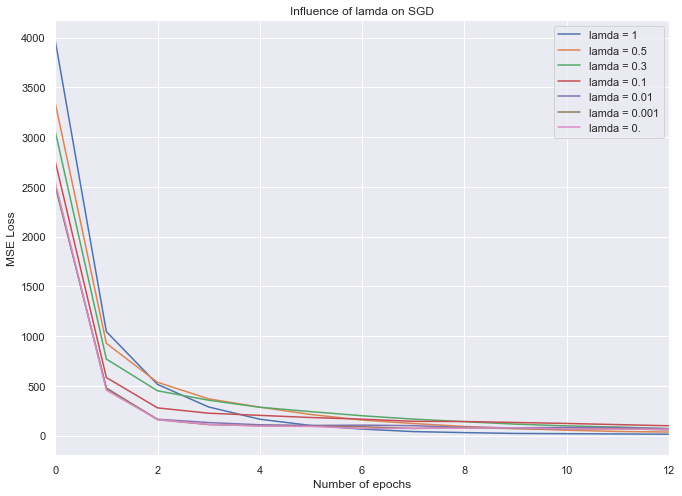

In [230]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_sgdreg_1, label='lamda = 1')
plt.plot(range(num_epochs), cost_history_sgdreg_2, label='lamda = 0.5')
plt.plot(range(num_epochs), cost_history_sgdreg_3, label='lamda = 0.3')
plt.plot(range(num_epochs), cost_history_sgdreg_4, label='lamda = 0.1')
plt.plot(range(num_epochs), cost_history_sgdreg_5, label='lamda = 0.01')
plt.plot(range(num_epochs), cost_history_sgdreg_6, label='lamda = 0.001')
plt.plot(range(num_epochs), cost_history_sgdreg_7, label='lamda = 0.')


plt.xlim([0, 12])
#plt.ylim([0, 0.015])
plt.title('Influence of lamda on SGD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

In [258]:
# création d'un vecteur prédictions qui contient les prédictions de notre modele final
predictions_sgd_reg2 = model(X_test, theta_final_sgd_5)
predictions_sgd_reg2.shape

(152, 1)

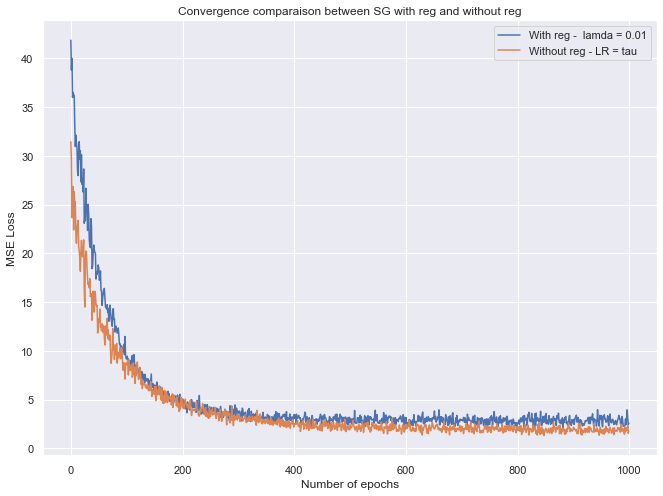

In [39]:
num_epochs = 1000


plt.plot(range(num_epochs), cost_history_sgdreg_5, label='With reg -  lamda = 0.01')
plt.plot(range(num_epochs), cost_history_sgd_tau, label='Without reg - LR = tau')




plt.title('Convergence comparaison between SG with reg and without reg')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

0.001
0.09140759066524055


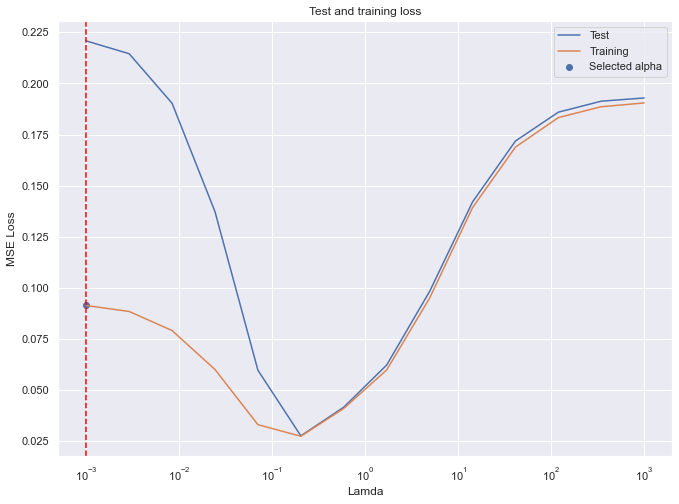

In [82]:
lamdas = np.logspace(-3, 3, 14)

train_values = []
test_values = []

for i in lamdas:
  
  theta_final_train, cost_history_train= stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = i,num_iters=1000)
  theta_final_test, cost_history_test= stochastic_gradient_descent_reg(X_test,y_test,theta,alpha = tau,lamda = i,num_iters=1000)
  
  predictions_test = model(X_test, theta_final_train)
  predictions_train = model(X_train, theta_final_test)


  mse_train= mse(predictions_train,y_train)
  mse_test = mse(predictions_test,y_test)

  train_values.append(mse_train)
  test_values.append(mse_test)

best_lamda_index = np.argmin(mse_test)
best_alpha = lamdas[best_lamda_index]
best_value = test_values[best_lamda_index]

print(best_alpha)
print(best_value)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(lamdas, train_values, label="Test")
plt.plot(lamdas, test_values, label="Training")
plt.scatter([best_alpha], [best_value], label="Selected alpha")
plt.axvline(best_alpha, color='red', linestyle='--')

#plt.ylim([0,0.10])

plt.xscale("log")

plt.title('Test and training loss')
plt.xlabel("Lamda")
plt.ylabel("MSE Loss")


plt.legend(loc="best")
plt.show() 

In [137]:
# the closed form functions (two methods)
def solve_ridge(X,y,lbda):
    return np.linalg.solve( X.T @ X + len(X) * lbda * np.identity(p), X.T @ y)

In [131]:
n_iter = 400
q = 14
lbda_list = np.logspace(-3,3,q)

J_train_Ridge = np.zeros(q) # the energy on the training set
J_test_Ridge = np.zeros(q) # the energy on the test set
E_train_Ridge = np.zeros(q) # the relative training error
E_test_Ridge = np.zeros(q) # the relative test error
W_Ridge = np.zeros((q,14)) # the coefficients


for i,lbda in enumerate(lbda_list):
    theta_final_train, cost_history_train= stochastic_gradient_descent_reg(X_train,y_train,theta,alpha = tau,lamda = i,num_iters=1000)
    
    J_train_Ridge[i] = LeastSquare.loss(X_train,y_train,theta_final_train)+Regularization.ridge(theta_final_train, lbda)
    J_test_Ridge[i] = LeastSquare.loss(X_test,y_test,theta_final_train)+Regularization.ridge(theta_final_train, lbda)
    E_train_Ridge[i] = LeastSquare.loss(X_train,y_train,theta_final_train)/np.linalg.norm(y_train)
    E_test_Ridge[i] = LeastSquare.loss(X_test,y_test,theta_final_train)/np.linalg.norm(y_test)
    W_Ridge[i] = theta_final_train.flatten()
    
# find optimal Lambda
i = E_test_Ridge.argmin(axis=0)
lambda_Ridge = lbda_list[i]
w_Ridge = W_Ridge[i][:,None]
print( 'Ridge: ' + str(E_test_Ridge.min()*100) + '%' )
print('lambda = {}'.format(lambda_Ridge))
# print('w = {}'.format(w_Ridge))

Ridge: 0.14685990675578184%
lambda = 0.001


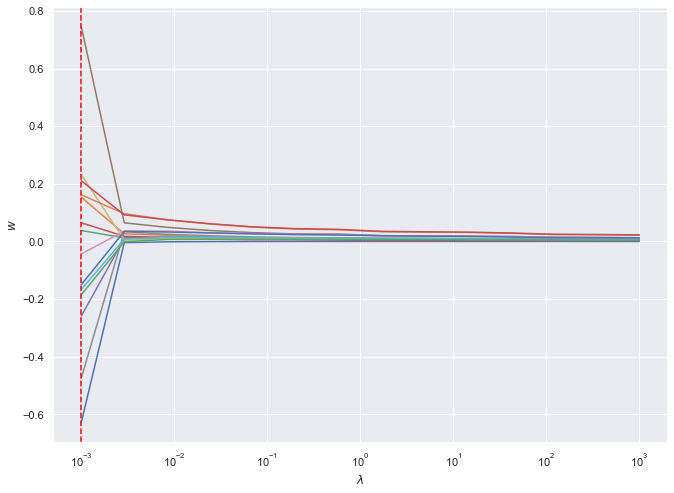

In [139]:
for k in range(p):
    plt.plot(lbda_list, W_Ridge[:,k])
plt.xlabel('$\lambda$')
plt.ylabel('$w$')
plt.axvline(lambda_Ridge, color='red', linestyle='--')
plt.xscale('log')
# plt.legend()
plt.show()

### Question 2 - L1 regularization

In [83]:
# take the operator norm of X
X_norm = LeastSquare.L(X_train.T @ X_train)
tau = 1/X_norm


Test of convergence of the method

Let's try for one value of lambda

In [84]:
lbda = 0.1
n_iter = 400
ista = ISTA(LeastSquare, 'lasso', lbda=lbda)
ista.multiple_steps(X_train, y_train, tau=tau, n=200)
# iast.single_step(X_train, y_train, np.zeros((X_train.shape[1],1)), tau)

array([[-0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.01238638],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.1370669 ],
       [ 0.        ],
       [ 0.14640265]])

The result clearly eliminates a lot of features.

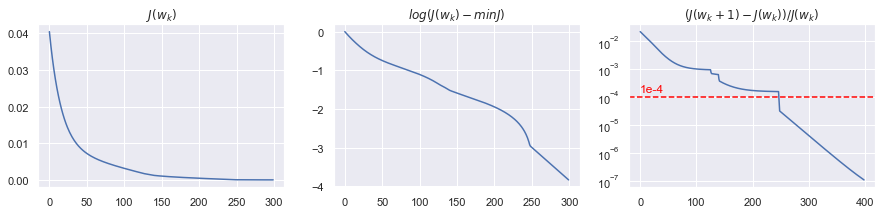

In [85]:
n_iter = 400
max_idx = 300
ista = ISTA(LeastSquare, 'lasso', lbda=lbda)
ista.multiple_steps(X_train, y_train, tau=tau, n=n_iter)

e=np.log10(ista.data['J'][:max_idx]-np.min(ista.data['J']) +1e-20)

plt.clf
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax[0].set_title('$J(w_k)$')
ax[1].set_title('$log(J(w_k)-min J)$')
ax[2].set_title('$(J(w_k+1)-J(w_k))/J(w_k)$')

ax[0].plot(ista.data['J'][:max_idx]-ista.data['J'][-1])
ax[1].plot(e-e[0])
ax[2].plot(-np.diff(ista.data['J'])/ista.data['J'][1:])
ax[2].axhline(1e-4, color='red', linestyle='--')
ax[2].text(0, 0.00015, '1e-4', color='red')
ax[2].set_yscale('log')

ax[0].axis('tight')
ax[1].axis('tight')

plt.show()

Determine the optimal lamda

In [87]:
n_iter = 400
q = X_train.shape[0]
lbda_list = np.logspace(-3,3,q)

E_train_Sparse = np.zeros(q)
E_test_Sparse = np.zeros(q)
W_Sparse = np.zeros((q,n_iter,14))


for i,lbda in enumerate(lbda_list):
    ista = ISTA(LeastSquare, 'lasso', lbda=lbda)
    w = ista.multiple_steps(X_train, y_train, tau=tau, n=n_iter)
    
    E_train_Sparse[i] = ista.loss.loss(X_train,y_train,w) #/np.linalg.norm(y_train)
    E_test_Sparse[i] = ista.loss.loss(X_test,y_test,w) #/np.linalg.norm(y_test)
    W_Sparse[i] = ista.data['W']
    
# find optimal Lambda for sparsity and fitting
i = E_test_Sparse.argmin()
lambda_Sparse = lbda_list[i]
w_Sparse = W_Sparse[i,-1,:][:,None]
print( 'Lasso: ' + str(E_test_Sparse.min()*100) + '%' )
print('lambda = {}'.format(lambda_Sparse))
# print('w = {}'.format(w_Sparse))

Lasso: 1.37467411882039%
lambda = 0.001


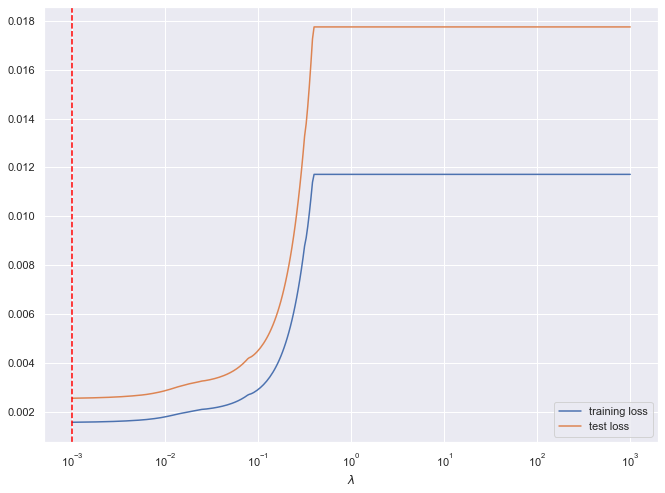

In [153]:
plt.clf
plt.plot(lbda_list, E_train_Sparse, label='training loss')
plt.plot(lbda_list, E_test_Sparse, label='test loss')
plt.axvline(lambda_Sparse, color='red', linestyle='--')
plt.xlabel('$\lambda$')
# plt.xlim(0.001,0.1)
plt.xscale('log')
plt.legend()
plt.show()

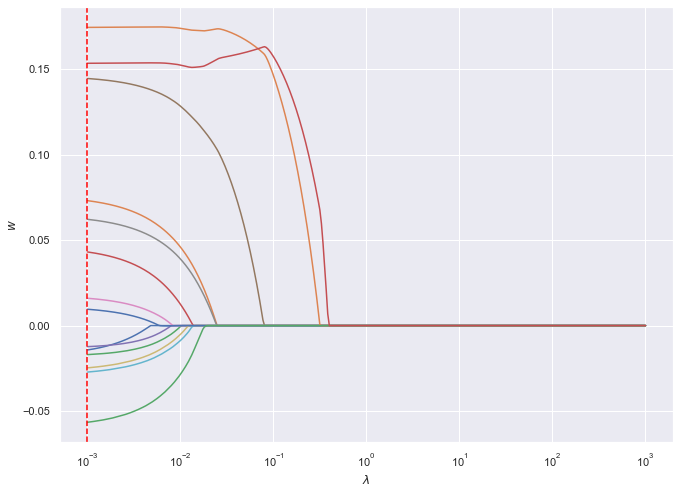

In [154]:
for k in range(p):
    plt.plot(lbda_list, W_Sparse[:,-1,k])
plt.xlabel('$\lambda$')
plt.ylabel('$w$')
plt.axvline(lambda_Sparse, color='red', linestyle='--')
plt.xscale('log')
# plt.legend()
plt.show()

In [164]:
X_train

array([[6.40875316e-02, 0.00000000e+00, 6.46627566e-01, ...,
        9.90342428e-01, 1.65838852e-01, 1.00000000e+00],
       [1.28706479e-03, 0.00000000e+00, 8.90762463e-02, ...,
        1.00000000e+00, 6.84326711e-02, 1.00000000e+00],
       [4.16433067e-04, 2.10000000e-01, 1.89882698e-01, ...,
        9.92611831e-01, 2.12472406e-01, 1.00000000e+00],
       ...,
       [3.06508225e-04, 7.50000000e-01, 9.12756598e-02, ...,
        9.96772404e-01, 6.89845475e-03, 1.00000000e+00],
       [5.96471525e-03, 0.00000000e+00, 2.10410557e-01, ...,
        9.53225074e-01, 2.73730684e-01, 1.00000000e+00],
       [3.28088562e-04, 2.50000000e-01, 1.61290323e-01, ...,
        9.84215039e-01, 1.59492274e-01, 1.00000000e+00]])

In [247]:
selected_vars_Sparse = np.where(w_Sparse!=0)[0]
selected_vars_Sparse

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)

In [263]:
liste_thetas = [w_Sparse, w_Ridge,theta_final_sgd_tau]

In [272]:
liste_mse_error_lamdas = []
liste_rmse_error_lamdas = []
liste_coeff_lamdas = []
for i in liste_thetas :
    predictions_lamdas = model(X_test, i)
    mse_error_lamdas = mse(predictions_lamdas,y_test)
    liste_mse_error_lamdas.append(mse_error_lamdas)
    rmse_error_lamdas = rmse(predictions_lamdas,y_test)
    liste_rmse_error_lamdas.append(rmse_error_lamdas)
    coeff_determination = coef_determination(y_test, predictions_lamdas)
    liste_coeff_lamdas.append(coeff_lamdas)

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of Lamdas')

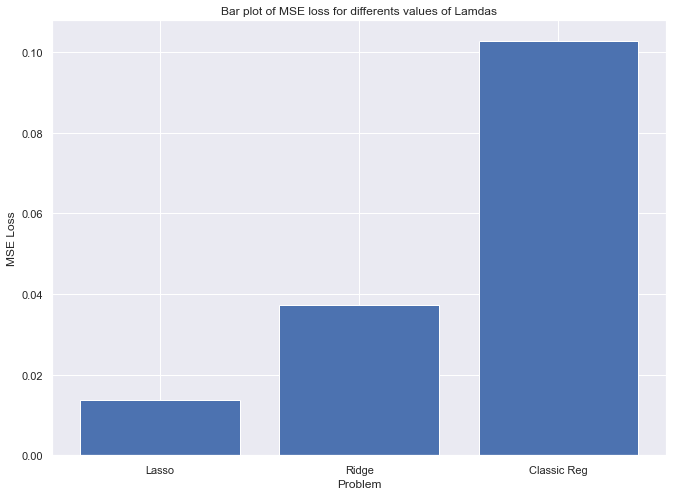

In [273]:
names = ['Lasso', 'Ridge', 'Classic Reg'] # nom des barres

values = liste_mse_error_lamdas

plt.bar(names, values)
plt.xlabel("Problem")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of Lamdas")

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of Lamdas')

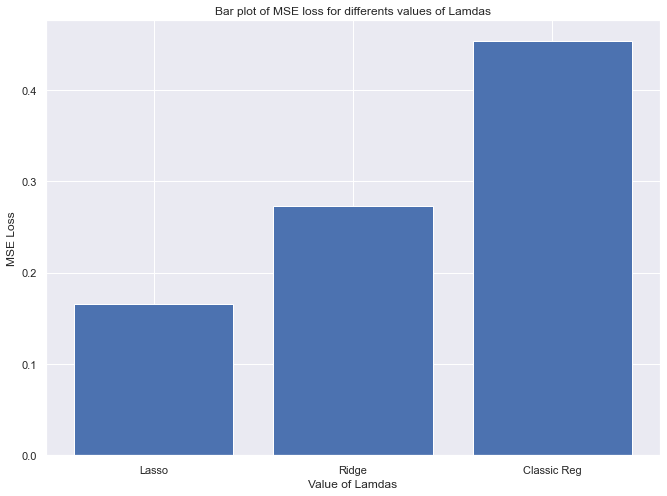

In [274]:
names = ['Lasso', 'Ridge', 'Classic Reg'] # nom des barres

values = liste_rmse_error_lamdas

plt.bar(names, values)
plt.xlabel("Value of Lamdas")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of Lamdas")

In [277]:
def mse(y_pred, y_true):
    return 1/(2*len(y_true))*np.linalg.norm(y_true - y_pred,2)**2

def relative_mse(y_pred, y_true):
    return 1/(2*len(y_true))*np.linalg.norm(y_true - y_pred,2)**2/np.linalg.norm(y_true)

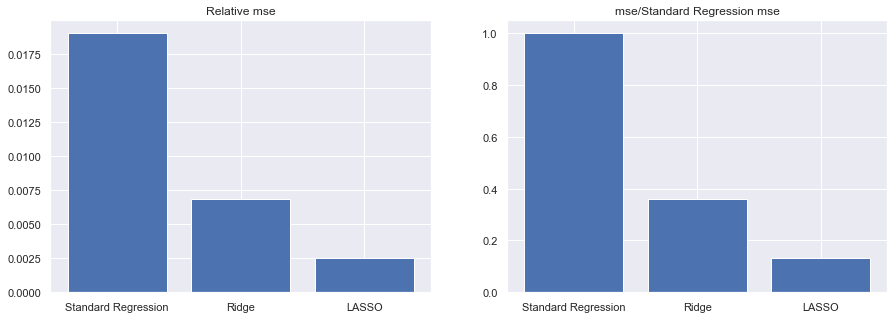

In [280]:
mse_perf = {
    'Standard Regression':relative_mse(X_test@theta_final_sgd_tau, y_test),
    'Ridge':relative_mse(X_test@w_Ridge, y_test),
    'LASSO':relative_mse(X_test@w_Sparse, y_test),
}

fig, ax = plt.subplots(ncols=2, figsize = (15,5))
ax[0].bar(range(len(mse_perf)), list(mse_perf.values()), align='center')
ax[0].set_xticks(range(len(mse_perf)))
ax[0].set_xticklabels(list(mse_perf.keys()))
ax[0].set_title('Relative mse')

ax[1].bar(range(len(mse_perf)), list(mse_perf.values())/mse_perf['Standard Regression'], align='center')
ax[1].set_xticks(range(len(mse_perf)))
ax[1].set_xticklabels(list(mse_perf.keys()))
ax[1].set_title('mse/Standard Regression mse')
plt.show()

Sparsity comparaison between L1 & L2 regularization

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (6).

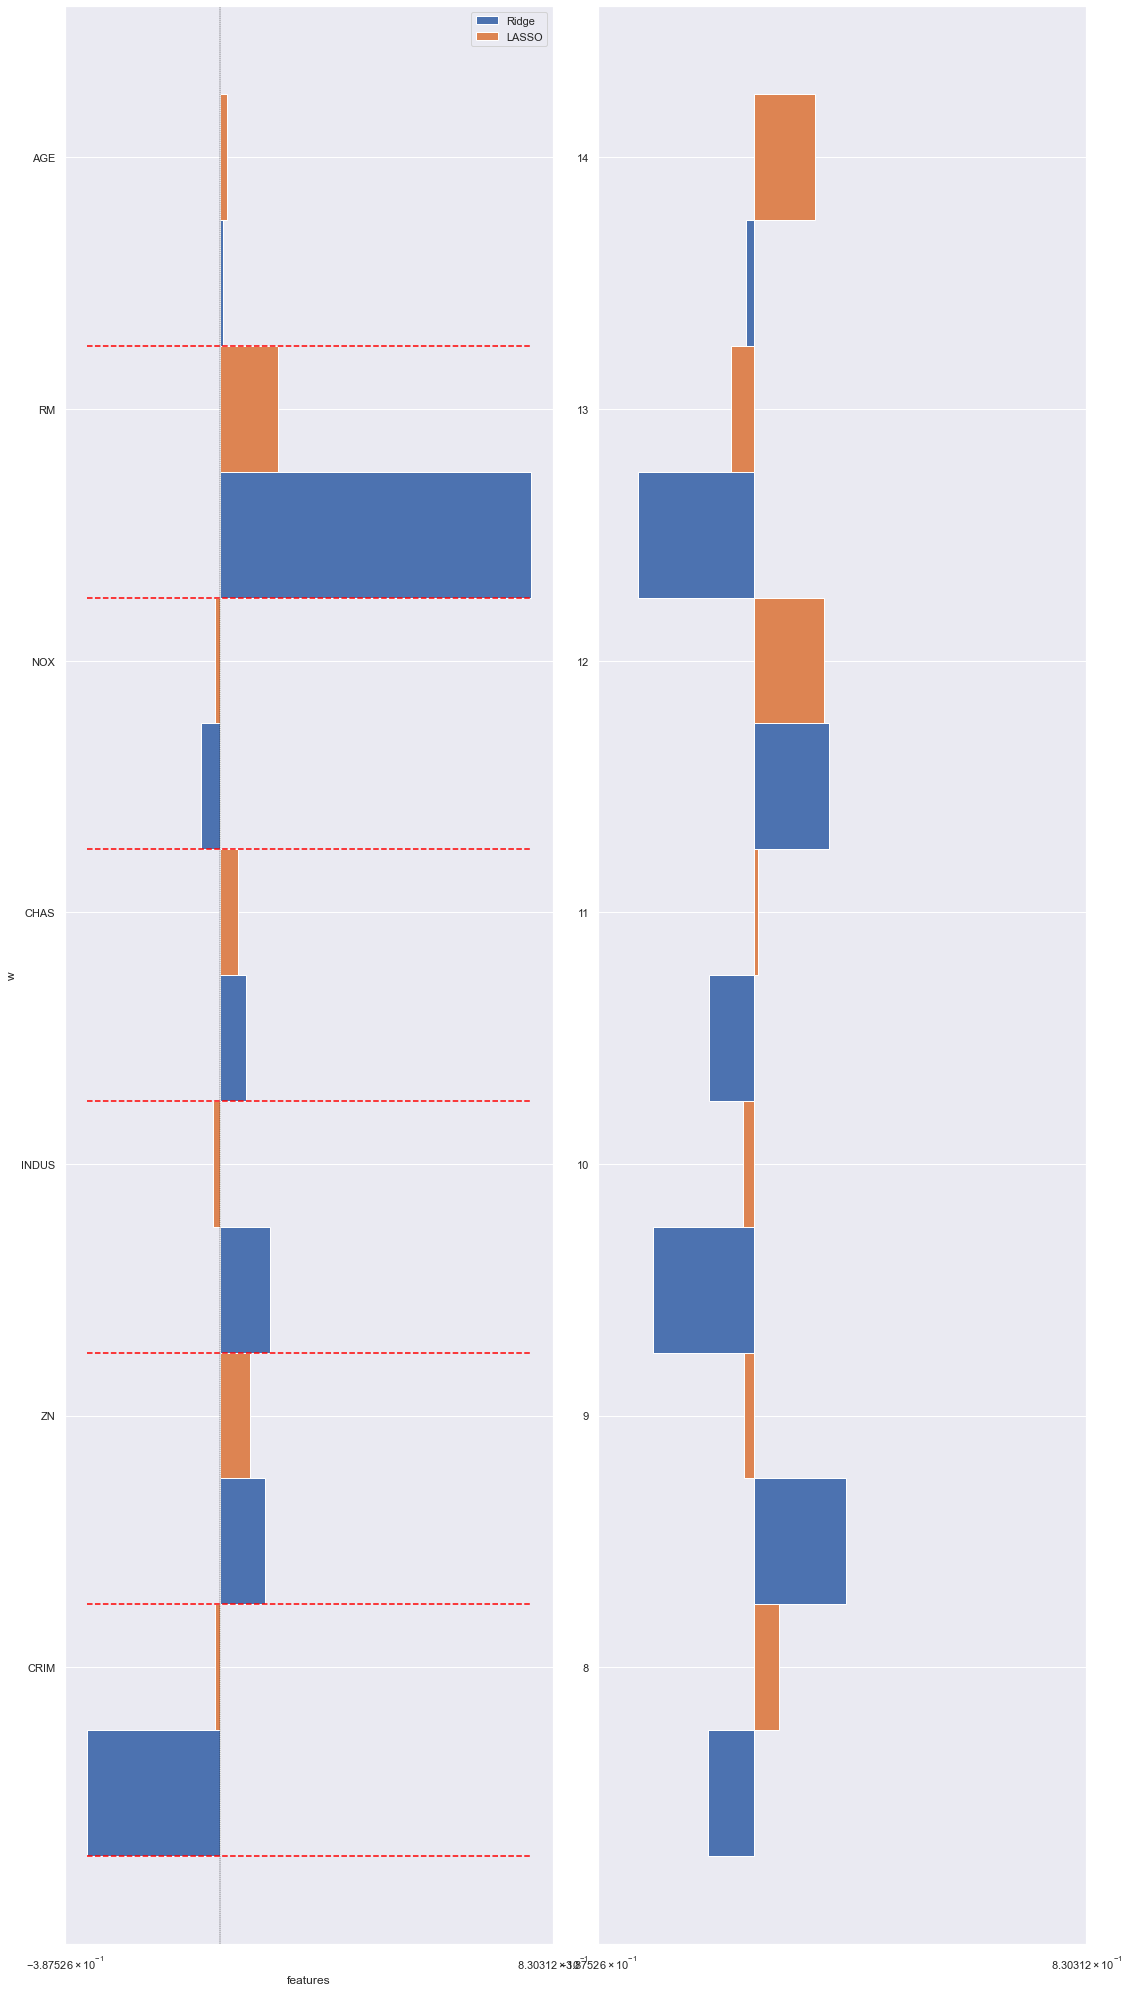

In [138]:
indices = np.arange(1,14+1) 

#parameters from the regularized model with lamda optimal = 0.001
Ws = {
      'Ridge':w_Ridge,
      'LASSO':w_Sparse,
 }

feature_colnames = X.columns
p=14
xmin, xmax = min(min(v) for v in Ws.values()), max(max(v) for v in Ws.values())
total_width = 1
width = total_width / len(Ws)
start_pos = -(len(Ws)%2)/2-len(Ws)//2

ncols=2
idx_cut = int(p/ncols)
fig, ax = plt.subplots(ncols=ncols, figsize=(15,30), sharex=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(ncols):
    idx_min, idx_max = i*idx_cut, min((i+1)*idx_cut, p)
    
    for j,(k,v) in enumerate(Ws.items()):
        ax[i].barh(indices[idx_min:idx_max]+start_pos*width+j*width, v[idx_min:idx_max,0], height=width, label=k)
    
#     ax[i].barh(indices[idx_min:idx_max]-2*width, w_Reg[idx_min:idx_max,0], height=width, label='Standard regression')
#     ax[i].barh(indices[idx_min:idx_max]-1*width, w_Sparse[idx_min:idx_max,0], height=width, label='LASSO')
#     ax[i].barh(indices[idx_min:idx_max]+1*width, w_Elastic[idx_min:idx_max,0], height=width, label='Elastic Net')
#     ax[i].barh(indices[idx_min:idx_max]+2*width, w_GroupLasso[idx_min:idx_max,0], height=width, label='Group LASSO')
    
    ax[i].set_yticks(indices[idx_min:idx_max])
    ax[i].set_yticklabels(list(feature_colnames[idx_min:idx_max]))
    
#     ax[i].axhline([5,10], color='red', linestyle='--')
    ax[i].hlines(indices[idx_min:idx_max]+start_pos*width-width/2, xmin=xmin, xmax=xmax, color='red', linestyle='--')
    ax[i].axvline(0, color='black', linestyle='--', linewidth=0.4)
    
    ax[i].set_xscale('symlog') # COMMENT THIS LINE TO GET A NORMAL SCALE
    
    ax[i].set_xlabel('features')
    ax[i].set_ylabel('w')
    ax[i].legend()

plt.subplots_adjust(wspace=0.35)
plt.suptitle('Comparison of coefficients of w for different methods')
plt.show()

## Part 6 - Large-scale and distributed optimization

In [31]:
theta = np.random.randn(14, 1)

Question 1 - Randomized block coordinate descent

In [32]:
def randomized_block_coordinate_descent(X, y, theta, alpha,block_size, num_iters):
    # Implement randomized block coordinate descent
    # X: input features
    # y: targets
    # w: model parameters
    # alpha: learning rate
    # num_iters: number of iterations
    # block_size: size of blocks

    m = np.size(y)
    J_history = np.zeros(num_iters)

    for i in range(num_iters):
        # Shuffle the blocks
        blocks = np.array_split(np.arange(theta.size), block_size)
        np.random.shuffle(blocks)

        cost = 0.0
        
        # Minimize the objective function with respect to each block
        for block in blocks:
            # Fix the values of all other blocks
            fixed_blocks = np.setdiff1d(np.arange(theta.size), block)
            
            # Randomly select a block
            block = np.random.choice(X.shape[1], block_size, replace=False)

            # And update all of the coordinates at time for each iterations
            h = model(X, theta) 
            X_block = X[:, block]
            gradient =  (np.dot(X_block.T, (h-y)))
            theta[block] -= alpha * (2 / m) * gradient #descent
        
            # Calculate the cost function for the updated model parameters
            cost += costFunction(X, y, theta)
        
        J_history[i] = cost
    
    return theta,J_history

In [33]:
d = X_train.shape[1]
print(d)

14


In [34]:
d = X_train.shape[1]

theta_bcd_1, cost_history_bcd_1 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,1, num_iters=1000) #1 blocks
theta_bcd_2, cost_history_bcd_2 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,2, num_iters=1000) #2 blocks
theta_bcd_3, cost_history_bcd_3 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,3, num_iters=1000) #3 blocks
theta_bcd_4, cost_history_bcd_4 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,4, num_iters=1000) #4 blocks 
theta_bcd_5, cost_history_bcd_5 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,9, num_iters=1000) #etc ..
theta_bcd_6, cost_history_bcd_6 = randomized_block_coordinate_descent(X_train, y_train,theta,tau,d, num_iters=1000)

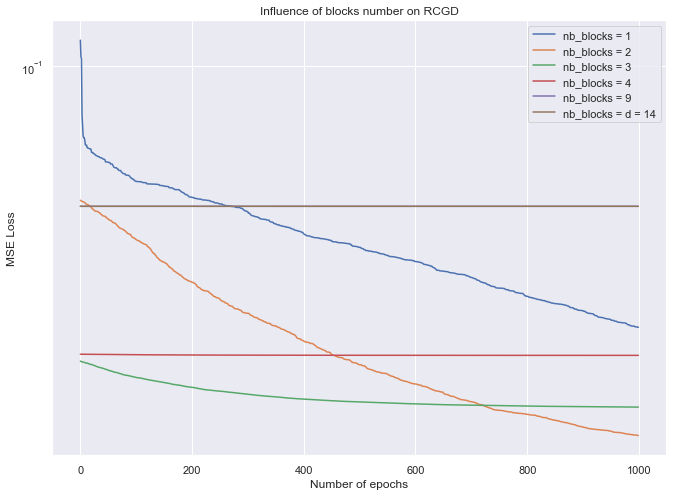

In [468]:
num_epochs = 1000
plt.semilogy(range(num_epochs), cost_history_bcd_1, label='nb_blocks = 1')
plt.semilogy(range(num_epochs), cost_history_bcd_2, label='nb_blocks = 2')
plt.semilogy(range(num_epochs), cost_history_bcd_3, label='nb_blocks = 3')
plt.semilogy(range(num_epochs), cost_history_bcd_4, label='nb_blocks = 4')
plt.semilogy(range(num_epochs), cost_history_bcd_5, label='nb_blocks = 9')
plt.semilogy(range(num_epochs), cost_history_bcd_5, label='nb_blocks = d = 14')

#plt.ylim([0,1])
plt.title('Influence of blocks number on RCGD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison with convergence GD

C:\Users\adrie\AppData\Local\Temp\ipykernel_9928\4127417881.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,0.05])


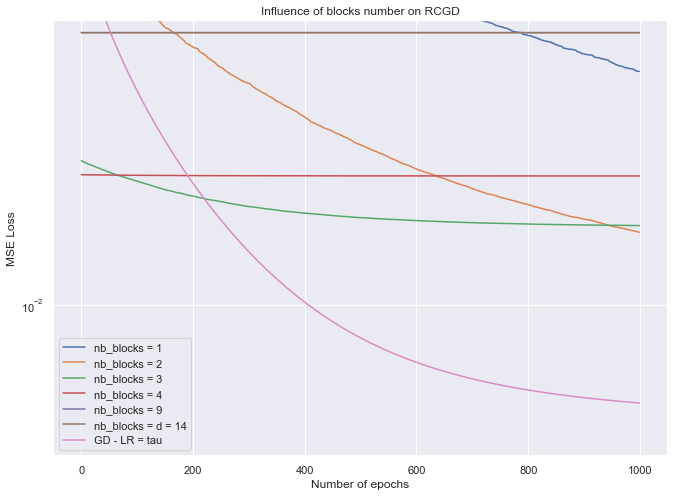

In [124]:
num_epochs = 1000

plt.semilogy(range(num_epochs), cost_history_bcd_1, label='nb_blocks = 1')
plt.semilogy(range(num_epochs), cost_history_bcd_2, label='nb_blocks = 2')
plt.semilogy(range(num_epochs), cost_history_bcd_3, label='nb_blocks = 3')
plt.semilogy(range(num_epochs), cost_history_bcd_4, label='nb_blocks = 4')
plt.semilogy(range(num_epochs), cost_history_bcd_5, label='nb_blocks = 9')
plt.semilogy(range(num_epochs), cost_history_bcd_5, label='nb_blocks = d = 14')



plt.semilogy(range(num_epochs), cost_history_tau, label='GD - LR = tau')

plt.ylim([0,0.05])
plt.title('Influence of blocks number on RCGD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Question 2 - Combine randomized block coordinate descent with stochastic gradient 

To combine randomized block coordinate descent with stochastic gradient, you will need to modify the block coordinate descent algorithm to use a random subset of the coordinates in each iteration instead of optimizing all of the coordinates at once.

In [138]:
theta = np.random.randn(14, 1)
theta.shape

(14, 1)

In [139]:
def randomized_block_coordinate_sgd_descent(X, y, theta, alpha,block_size, num_iters):
    """
    Implements randomized block coordinate descent with stochastic gradient for optimization.
    
    Parameters:
    - X: training data, numpy array of shape (n_samples, n_features)
    - y: training labels, numpy array of shape (n_samples,)
    - w: initial weights, numpy array of shape (n_features,)
    - alpha: learning rate
    - max_iter: maximum number of iterations
    - block_size: size of the blocks to update
    
    Returns:
    - w: optimized weights, numpy array of shape (n_features,)
    """

    m = np.size(y)
    J_history = np.zeros(num_iters)

    n_samples, n_features = X.shape
    n_blocks = n_features // block_size
    
    for i in range(num_iters):
        # Shuffle the blocks
        blocks = np.random.permutation(n_blocks)

        cost = 0.0
        
        for block in blocks:

            random_select = np.random.randint(0, m)
            
             # Select a random sample
            x_i = X[random_select,:].reshape(1,X.shape[1])
            y_i = y[random_select].reshape(1,1)


            # Randomly select a block
            block = np.random.choice(X.shape[1], block_size, replace=False)

             # And update all of the coordinates at time for each iterations
            h = model(x_i, theta) 
            X_block = x_i[:, block]
            gradient =  (np.dot(X_block.T, (h-y_i)))

            # Update the weights in the block using the stochastic gradient
            theta[block] -= alpha * (2 / m) * gradient #descent
            
            # Calculate the cost function for the updated model parameters
            cost += costFunction(x_i, y_i,theta)

        J_history[i] = cost
        
    
    return theta,J_history

In [140]:
d = X_train.shape[1]

theta_bcd_sgd_1, cost_history_bcd_sgd_1 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,1, num_iters=1000) #1 block
theta_bcd_sgd_2, cost_history_bcd_sgd_2 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,2, num_iters=1000) #2 blocks
theta_bcd_sgd_3, cost_history_bcd_sgd_3 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,3, num_iters=1000) #3 blocks
theta_bcd_sgd_4, cost_history_bcd_sgd_4 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,4, num_iters=1000) #4 blocks 
theta_bcd_sgd_5, cost_history_bcd_sgd_5 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,9, num_iters=1000) #etc ..
theta_bcd_sgd_6, cost_history_bcd_sgd_6 = randomized_block_coordinate_sgd_descent(X_train, y_train,theta,tau,d, num_iters=1000)

C:\Users\adrie\AppData\Local\Temp\ipykernel_9928\2521130806.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,90])


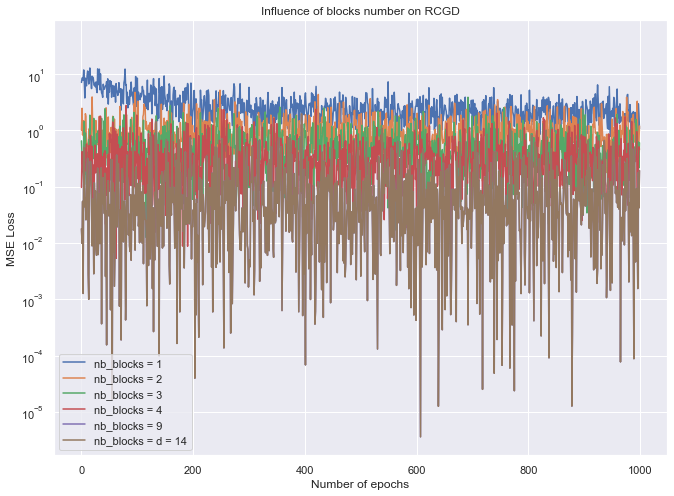

In [143]:
num_epochs = 1000
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_1, label='nb_blocks = 1')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_2, label='nb_blocks = 2')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_3, label='nb_blocks = 3')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_4, label='nb_blocks = 4')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_5, label='nb_blocks = 9')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_5, label='nb_blocks = d = 14')

plt.ylim([0,90])
plt.title('Influence of blocks number on RCGD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison convergence between Gradient Descent VS RCGD VS RCGD stochastic

C:\Users\adrie\AppData\Local\Temp\ipykernel_9928\391139727.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,90])


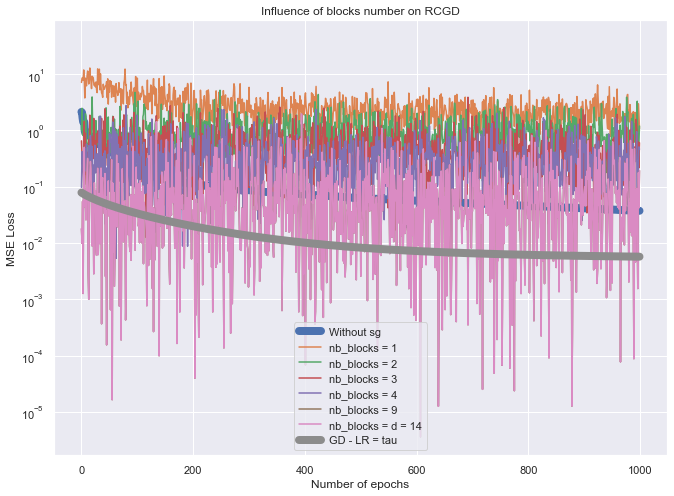

In [142]:
num_epochs = 1000

plt.semilogy(range(num_epochs), cost_history_bcd_1,linewidth=8, label='Without sg')


plt.semilogy(range(num_epochs), cost_history_bcd_sgd_1, label='nb_blocks = 1')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_2, label='nb_blocks = 2')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_3, label='nb_blocks = 3')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_4, label='nb_blocks = 4')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_5, label='nb_blocks = 9')
plt.semilogy(range(num_epochs), cost_history_bcd_sgd_5, label='nb_blocks = d = 14')



plt.semilogy(range(num_epochs), cost_history_tau, label='GD - LR = tau', linewidth=8)

plt.ylim([0,90])
plt.title('Influence of blocks number on RCGD')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

In [127]:
liste_thetas_cd = [theta_final_tau,theta_bcd_2,theta_bcd_sgd_1]

In [128]:
liste_mse_error_scd = []
liste_rmse_error_scd = []
liste_coeff_determination_scd = []
for i in liste_thetas_cd :
    predictions_scd = model(X_test, i)
    mse_error_scd = mse(predictions_scd,y_test)
    liste_mse_error_scd.append(mse_error_scd)
    rmse_error_scd = rmse(predictions_scd,y_test)
    liste_rmse_error_scd.append(rmse_error_scd)
    coeff_determination_scd = coef_determination(y_test, predictions_scd)
    liste_coeff_determination_scd.append(coeff_determination_scd)

Text(0.5, 1.0, 'Bar plot of MSE loss for GD and RB coordinate decent')

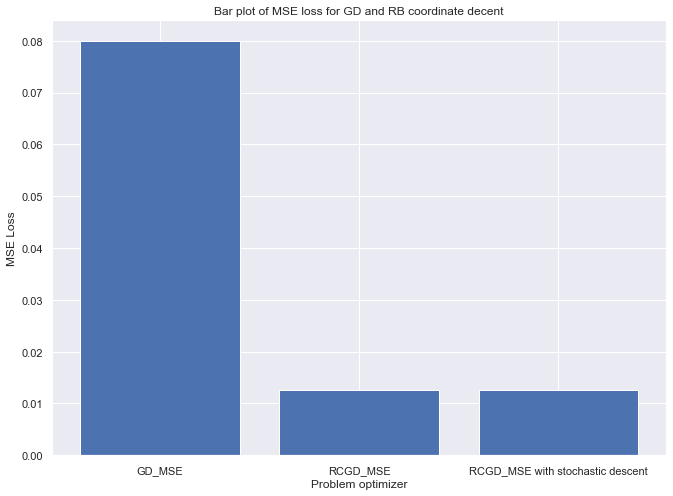

In [129]:
names = ['GD_MSE', 'RCGD_MSE', "RCGD_MSE with stochastic descent"] # nom des barres

values = liste_mse_error_scd

plt.bar(names, values)
plt.xlabel("Problem optimizer")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for GD and RB coordinate decent")

Text(0.5, 1.0, 'Bar plot of MSE loss for GD and RB coordinate decent')

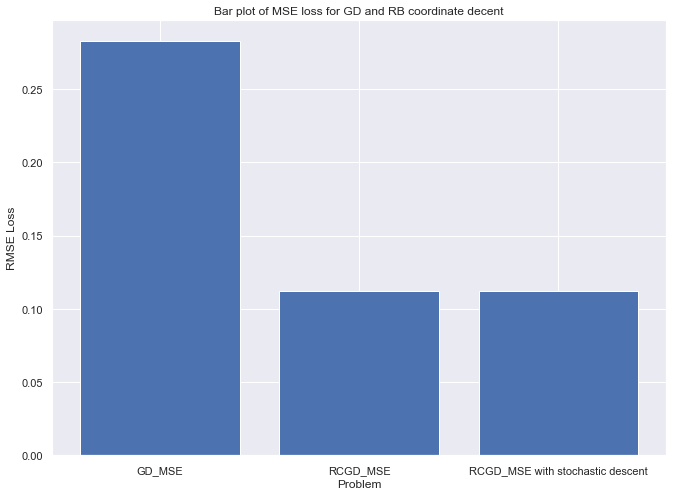

In [130]:
names = ['GD_MSE', 'RCGD_MSE', "RCGD_MSE with stochastic descent"] # nom des barres

values = liste_rmse_error_scd

plt.bar(names, values)
plt.xlabel("Problem")
plt.ylabel("RMSE Loss")
plt.title("Bar plot of MSE loss for GD and RB coordinate decent")

### Part 7  - Advanced topics on gradient descent

In [89]:
import math

In [90]:
theta = np.random.randn(14, 1)
theta.shape

(14, 1)

Question 1 - Heavy Ball method

In [91]:
def gradient_descent_heavy_ball(X,y,theta,lamda,alpha,gamma,num_iters):
    '''Gradient descent for regression'''
    #Initialisation of useful values 
    size = np.size(y)
    
    J_history = np.zeros(num_iters)

    m = 0
    for i in range(0, num_iters):
        #Hypothesis function
        h = model(X, theta)

        m = (1-gamma) * (np.dot(X.T, (h-y))) + gamma * m + lamda*theta
        
        theta = theta - alpha *(1/size) * m  # "gradient" step
        #theta = theta - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * theta )
        
        #Cost function in vectorized form       
        J_history[i] = costFunctionReg(X,y,theta,lamda)
           

    return theta,J_history

In [92]:
tau_1 = 2/L
tau_2 = 1/L
tau_3 = 0.5/L
tau_4 = 0.1/L
tau_5 = 0.05/L

Test for differents experimental gamma momentum 

In [93]:
theta_final_hb1_gamma, cost_history_hb1_gamma  = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau,gamma = 0,num_iters=1000)
theta_final_hb2_gamma, cost_history_hb2_gamma  = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau,gamma = 0.5,num_iters=1000)
theta_final_hb3_gamma, cost_history_hb3_gamma  = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau,gamma = 0.90,num_iters=1000)
theta_final_hb4_gamma, cost_history_hb4_gamma  = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau,gamma = 0.95,num_iters=1000)
theta_final_hb5_gamma, cost_history_hb5_gamma  = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau,gamma = 0.99,num_iters=1000)

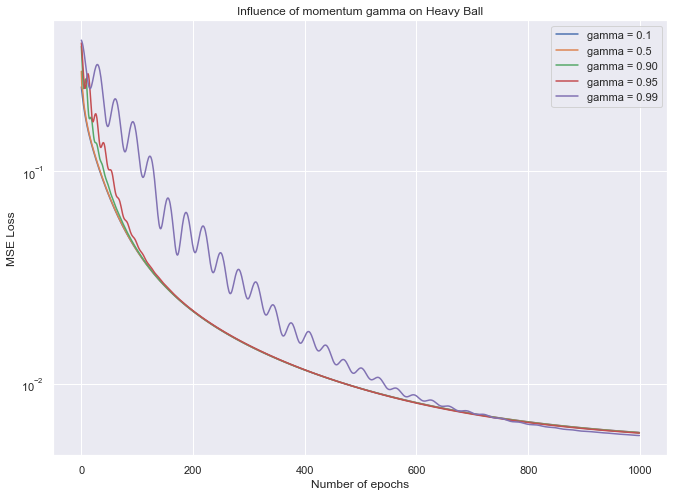

In [40]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_hb1_gamma, label='gamma = 0.1')
plt.plot(range(num_epochs), cost_history_hb2_gamma, label='gamma = 0.5')
plt.plot(range(num_epochs), cost_history_hb3_gamma, label='gamma = 0.90')
plt.plot(range(num_epochs), cost_history_hb4_gamma, label='gamma = 0.95')
plt.plot(range(num_epochs), cost_history_hb5_gamma, label='gamma = 0.99')

#plt.plot(range(num_epochs), cost_history_tau, label='GD - tau = 1/L')

plt.yscale("log")


plt.title('Influence of momentum gamma on Heavy Ball')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Comparaison with gradient descent

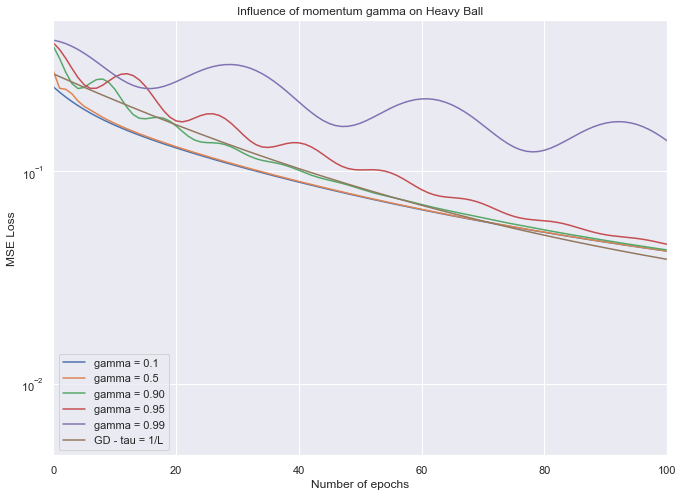

In [41]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_hb1_gamma, label='gamma = 0.1')
plt.plot(range(num_epochs), cost_history_hb2_gamma, label='gamma = 0.5')
plt.plot(range(num_epochs), cost_history_hb3_gamma, label='gamma = 0.90')
plt.plot(range(num_epochs), cost_history_hb4_gamma, label='gamma = 0.95')
plt.plot(range(num_epochs), cost_history_hb5_gamma, label='gamma = 0.99')

plt.plot(range(num_epochs), cost_history_tau, label='GD - tau = 1/L')

plt.yscale("log")

plt.xlim([-1,10])
plt.xlim([0,100])
plt.title('Influence of momentum gamma on Heavy Ball')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Test for differents tau learning rates and comparaison with gradient descent

In [94]:
theta_final_hb1_alpha, cost_history_hb1_alpha = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau_1,gamma = 0.540,num_iters=1000)
theta_final_hb2_alpha, cost_history_hb2_alpha = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau_2,gamma = 0.540,num_iters=1000)
theta_final_hb3_alpha, cost_history_hb3_alpha = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau_3,gamma = 0.540,num_iters=1000)
theta_final_hb4_alpha, cost_history_hb4_alpha = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau_4,gamma = 0.540,num_iters=1000)
theta_final_hb5_alpha, cost_history_hb5_alpha = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha = tau_5,gamma = 0.540,num_iters=1000)

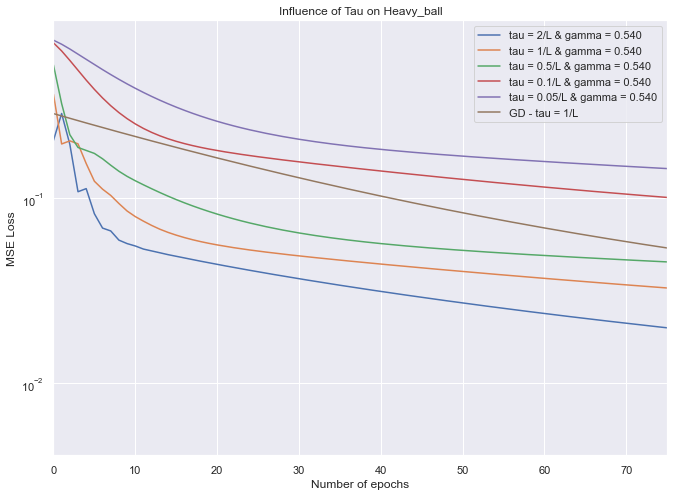

In [64]:
num_epochs = 1000
plt.plot(range(num_epochs), cost_history_hb1_alpha, label='tau = 2/L & gamma = 0.540')
plt.plot(range(num_epochs), cost_history_hb2_alpha, label='tau = 1/L & gamma = 0.540')
plt.plot(range(num_epochs), cost_history_hb3_alpha, label='tau = 0.5/L & gamma = 0.540')
plt.plot(range(num_epochs), cost_history_hb4_alpha, label='tau = 0.1/L & gamma = 0.540')
plt.plot(range(num_epochs), cost_history_hb5_alpha, label='tau = 0.05/L & gamma = 0.540')

plt.plot(range(num_epochs), cost_history_tau, label='GD - tau = 1/L')


plt.yscale("log")

plt.xlim([0,75])
plt.title('Influence of Tau on Heavy_ball')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

Grid search gamma for confirmation

In [37]:
def loss(X_n,A,y):
    return np.mean(1/2*np.square(A@X_n-y))

100%|██████████| 3/3 [00:00<00:00, 59.92it/s]


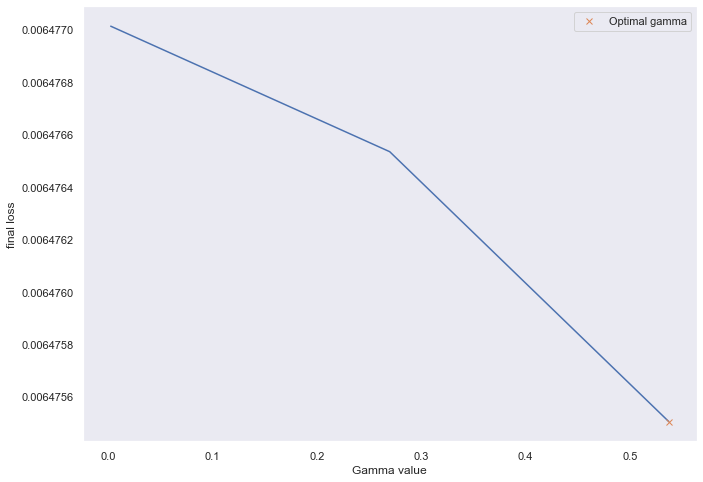

0.5370489885883543


In [38]:
from tqdm import tqdm

L_loss =[]

min=100
gamma_opt = ((math.sqrt(1)-math.sqrt(0.1))**2) / ((math.sqrt(1)+math.sqrt(0.1))**2)
gamma_i = [gamma_opt*(1+i) for i in np.arange(-0.99,1,0.99)]
for i in tqdm(gamma_i):
    #theta_lamda_optimal = heavy_ball(A_train,y_train,eps=1e-3,gamma=0.1,lr=i)
    theta_final_alpha_th, cost_history_alpha_th = gradient_descent_heavy_ball(X_train,y_train,theta,0.001,alpha =tau,gamma = i,num_iters=1000)
    l = loss(theta_final_alpha_th,X_test,y_test)
    if l <min:
        min=l
        min_gamma = i
    L_loss.append(l)

plt.figure(1)
plt.plot(gamma_i,L_loss)
plt.plot(min_gamma,l,'x',label='Optimal gamma')
plt.xlabel('Gamma value')
plt.ylabel('final loss')
plt.xlim()
plt.ylim()
plt.grid()
plt.legend()
plt.show()
print(min_gamma)



Metrics comparaison of our problem with fixed momentum gamma = 0.99 and differents values of lamda + comparaison with Gradient descent

In [77]:
list_thetas_hb = [theta_final_hb6_alpha,theta_final_hb7_alpha,theta_final_hb8_alpha,theta_final_hb9_alpha,theta_final_hb10_alpha, theta_final_hb_theoretical,theta_final_alpha_th,theta_final_tau]

In [78]:
liste_mse_error_hb = []
liste_rmse_error_hb = []
liste_coeff_hb = []
for i in list_thetas_hb :
    predictions_hb = model(X_test, i)
    mse_error_hb = mse(predictions_hb,y_test)
    liste_mse_error_hb.append(mse_error_hb)
    rmse_error_hb = rmse(predictions_hb,y_test)
    liste_rmse_error_hb.append(rmse_error_hb)
    coeff_hb = coef_determination(y_test, predictions_hb)
    liste_coeff_hb.append(coeff_hb)

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of Lamdas')

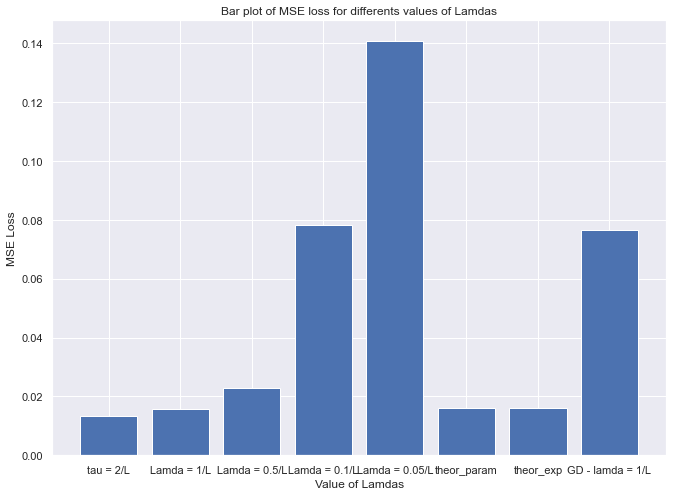

In [81]:
names = ['tau = 2/L', 'Lamda = 1/L', 'Lamda = 0.5/L', 'Lamda = 0.1/L','Lamda = 0.05/L', 'theor_param', 'theor_exp', 'GD - lamda = 1/L'] # nom des barres

values = liste_mse_error_hb

plt.bar(names, values)
plt.xlabel("Value of Lamdas")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of Lamdas")

Metrics comparaison of our problem with fixed lamda and differents values of beta + comparaison with Gradient descent

In [95]:
list_thetas_hb_gamma = [theta_final_hb1_gamma,theta_final_hb2_gamma,theta_final_hb3_gamma,theta_final_hb4_gamma,theta_final_hb5_gamma,theta_final_tau]

In [96]:
liste_mse_error_hb = []
liste_rmse_error_hb = []
liste_coeff_hb = []
for i in list_thetas_hb_gamma :
    predictions_hb = model(X_test, i)
    mse_error_hb = mse(predictions_hb,y_test)
    liste_mse_error_hb.append(mse_error_hb)
    rmse_error_hb = rmse(predictions_hb,y_test)
    liste_rmse_error_hb.append(rmse_error_hb)
    coeff_hb = coef_determination(y_test, predictions_hb)
    liste_coeff_hb.append(coeff_hb)

In [97]:
print(liste_mse_error_hb)

[0.014945188336672846, 0.014938570660428585, 0.01488558790932038, 0.014819275590034823, 0.014148308439449668, 0.07688343466312603]


Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of gammas')

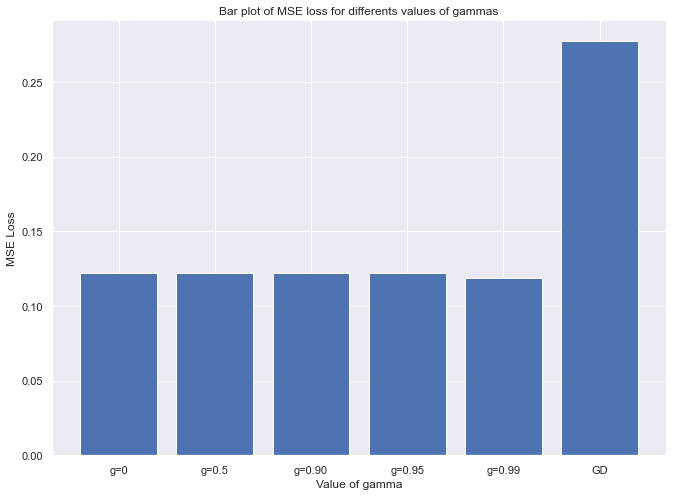

In [99]:
names = ['g=0', 'g=0.5', 'g=0.90', 'g=0.95','g=0.99','GD'] # nom des barres

values = liste_rmse_error_hb

plt.bar(names, values)

plt.xlabel("Value of gamma")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of gammas")

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of gammas')

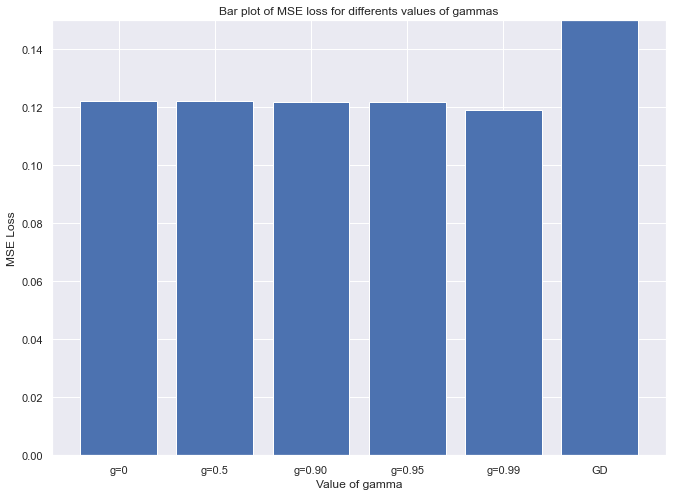

In [98]:
#zoom

names = ['g=0', 'g=0.5', 'g=0.90', 'g=0.95','g=0.99','GD'] # nom des barres

values = liste_rmse_error_hb

plt.bar(names, values)
plt.ylim([0,0.15])
plt.xlabel("Value of gamma")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of gammas")

Question 3 - Apply GD to a non-convex loss function :  addition of a non-convex penalty to our convex objective

In [207]:
def gradient_descent_non_convex(X,y,eps,alpha,lamda,p,itemax):
    theta = np.random.randn(14, 1)
    grad = np.array([1000]*X.shape[1])
    if alpha == None:
        alpha = 1/np.linalg.norm(X,2)**2   

    l_loss = []
    i = 0
    while i<itemax:
        y_pred = X.dot(theta)
        grad = np.dot(X.T,(y_pred-y))+lamda*(p*(np.abs(theta)**(p-1))) #add non convex reg
        theta = theta - alpha*grad 
        l_loss.append((1/2*(y_pred-y)**2+lamda*np.sum(np.abs(theta)**p)).mean())
        i+=1
        
    return theta,l_loss



In [208]:
theta_noconv_1, l_loss_no_conv_1 = gradient_descent_non_convex(X_train,y_train,eps=1e-2,alpha = None,lamda= 0.01,p=0.8,itemax=1000)
theta_noconv_2, l_loss_no_conv_2 = gradient_descent_non_convex(X_train,y_train,eps=1e-2,alpha = None,lamda= 0.01,p=0.5,itemax=1000)
theta_noconv_3, l_loss_no_conv_3 = gradient_descent_non_convex(X_train,y_train,eps=1e-2,alpha = None,lamda= 0.01,p=0.3,itemax=1000)
theta_noconv_4, l_loss_no_conv_4 = gradient_descent_non_convex(X_train,y_train,eps=1e-2,alpha = None,lamda= 0.01,p=0.1,itemax=1000)

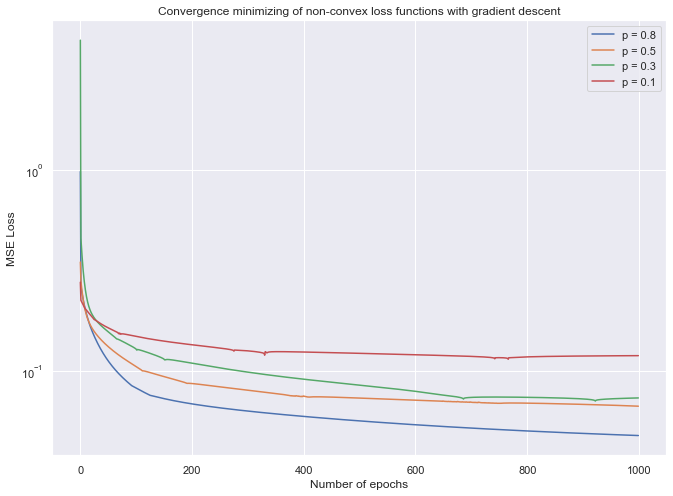

In [209]:
num_epochs = 1000
plt.plot(range(num_epochs), l_loss_no_conv_1 , label='p = 0.8')
plt.plot(range(num_epochs), l_loss_no_conv_2 , label='p = 0.5')
plt.plot(range(num_epochs), l_loss_no_conv_3 , label='p = 0.3')
plt.plot(range(num_epochs), l_loss_no_conv_4 , label='p = 0.1')



plt.yscale("log")

#plt.xlim([0,1000])
plt.title('Convergence minimizing of non-convex loss functions with gradient descent')
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.legend()

In [229]:
list_p = [theta_noconv_1,theta_noconv_2,theta_noconv_3,theta_noconv_4]

In [230]:
liste_mse_error_p = []
liste_rmse_error_p = []
liste_coeff_hb = []
for i in list_p :
    predictions_p = model(X_test, i)
    mse_error_p = mse(predictions_p,y_test)
    liste_mse_error_p.append(mse_error_p)
    rmse_error_p = rmse(predictions_p,y_test)
    liste_rmse_error_p.append(rmse_error_p)
    coeff_p = coef_determination(y_test, predictions_p)
    liste_coeff_hb.append(coeff_p)

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of p')

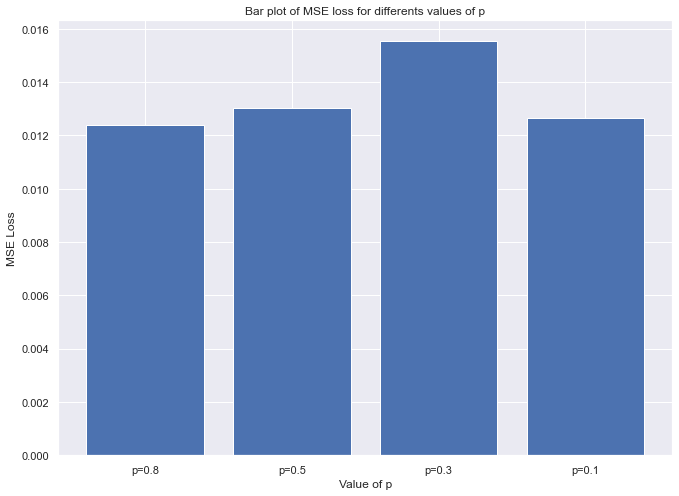

In [231]:
names = ['p=0.8', 'p=0.5', 'p=0.3','p=0.1'] # nom des barres

values = liste_mse_error_p

plt.bar(names, values)
plt.xlabel("Value of p")
plt.ylabel("MSE Loss")
plt.title("Bar plot of MSE loss for differents values of p")

Text(0.5, 1.0, 'Bar plot of MSE loss for differents values of p')

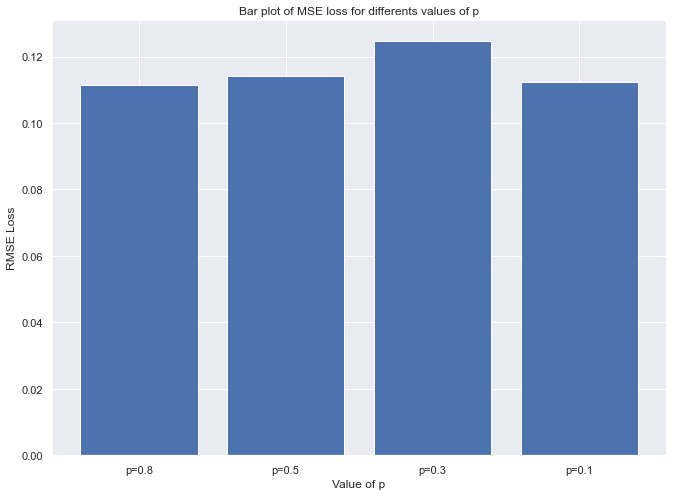

In [232]:
names = ['p=0.8', 'p=0.5', 'p=0.3','p=0.1'] # nom des barres

values = liste_rmse_error_p

plt.bar(names, values)
plt.xlabel("Value of p")
plt.ylabel("RMSE Loss")
plt.title("Bar plot of MSE loss for differents values of p")

Text(0.5, 1.0, 'Bar plot of Coeff Determination for differents values of p')

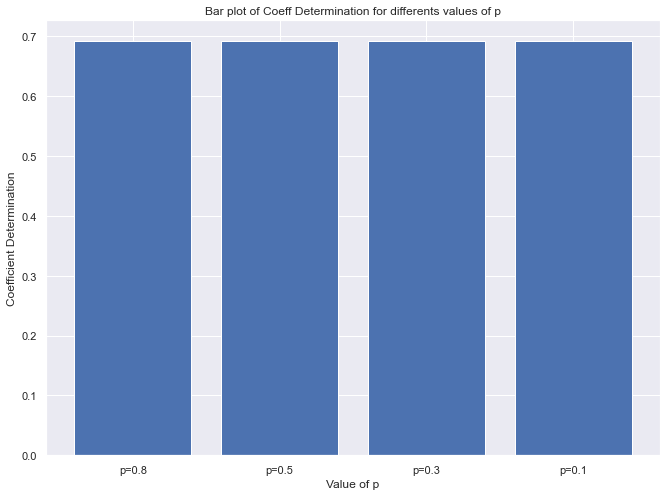

In [233]:
names = ['p=0.8', 'p=0.5', 'p=0.3','p=0.1'] # nom des barres

values = coeff_p

plt.bar(names, values)
plt.xlabel("Value of p")
plt.ylabel("Coefficient Determination")
plt.title("Bar plot of Coeff Determination for differents values of p")